# Model Analysis for HAM10k data

Results for preliminary ResNet training without KD. Some of these experiments helped establish the setup when taclking main reserach questions

In [1]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as pyo
pyo.init_notebook_mode()
import plotly.io as pio
import numpy as np
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
import math
import re
import os
import seaborn as sns
plt.rcParams['figure.dpi'] = 150

In [2]:
# DEFINE CONSTANTS

TEACHER_IDS = [
    'r50-sam1-s44',
    'r101-sam1-s43',
    'r101-sam0-s43',
    'r101-sam2-s42',
]

TEACHER_NAMES = {
    'r101-sam1-s43': 'ResNet101\nWeighted\nSampling',
    'r101-sam0-s43': 'ResNet101\nNo Sampling',
    'r50-sam1-s44': 'ResNet50\nWeighted\nSampling',
    'r101-sam2-s42': 'ResNet101\nSubgroup\nSampling',
}

TEACHER_SAMPLING = {
    'r101-sam1-s43': 1,
    'r101-sam0-s43': 0,
    'r50-sam1-s44': 1,
    'r101-sam2-s42': 2,
}

SAMPLING_TECHNIQUES_NAMES = {
    0: 'NO',
    1: 'RANDOM WEIGHTED',
    2: 'SUBGROUP',
}

## Read ResNet data

In [3]:
results_path = '../../results/ham10000/resnet/predictions/'

test_data = []
val_data = []

for folder in os.scandir(results_path):
    if folder.is_dir():
        # Perform operations on the folder
        file_path = results_path + folder.name
        if os.path.exists(file_path + '/test.csv'):
            df_tmp = pd.read_csv(file_path + '/test.csv')
            test_data.append(df_tmp)
            
        if os.path.exists(file_path + '/val.csv'):
            df_tmp = pd.read_csv(file_path + '/val.csv')
            val_data.append(df_tmp)

    
resnet_test_df = pd.concat(test_data)    
resnet_val_df = pd.concat(val_data)

resnet_test_df.to_csv('resnet.csv')

## Read KD Data

In [5]:
results_path = '../../results/ham10000/kd/vanilla/'

test_data = []
val_data = []

for folder in os.scandir(results_path):
    if folder.is_dir():
        # Perform operations on the folder
        file_path = results_path + folder.name
        if os.path.exists(file_path + '/test.csv'):
            df_tmp = pd.read_csv(file_path + '/test.csv')
            test_data.append(df_tmp)
            
        if os.path.exists(file_path + '/val.csv'):
            df_tmp = pd.read_csv(file_path + '/val.csv')
            val_data.append(df_tmp)
    
kd_test_df = pd.concat(test_data)    
kd_val_df = pd.concat(val_data)

# DON'T INCLUDE THE DATA WHERE THE TEACHER IS NON-SAMPLED AND STUDENTS ARE SAMPLED
# mask_1 = (kd_test_df['teacher_id'] == 'r101-sam0-s43') & (kd_test_df['sampling_technique'].isin([1, 2]))
# kd_test_df = kd_test_df[~mask_1]

# Exclude resnet50 as student model
kd_test_df = kd_test_df[kd_test_df['model_name'] != 'resnet50'] 

## Combine the dataframes

## ResNet Performance Analysis

### ResNet Average Performance Per Sampling technique

In [247]:
def plot_resnet_per_sampling_performance(
    df: pd.DataFrame,
    metric: str,
    labels: list[str] = [
        'No sampling',
        'Random weighted sampling',
        'Subgroup sampling'
    ],
    title: str = 'Avg ResNet performance per sampling technique for HAM10k'
):
    plt.rcParams['figure.dpi'] = 150
    x_label_order = ['resnet18', 'resnet34', 'resnet50', 'resnet101']
    df['model_name'] = pd.Categorical(df['model_name'], x_label_order)
    # Split dataframes
    no_sampling_df = df[df['sampling_technique'] == 0].sort_values('model_name')
    random_weighted_sampling_df = df[df['sampling_technique'] == 1].sort_values('model_name')
    subgroup_sampling_df = df[df['sampling_technique'] == 2].sort_values('model_name')

    # get the labels
    label_1, label_2, label_3 = labels

    # Add avg metric
    avg_metric = 'avg_' + metric
    no_sampling_df[avg_metric] = no_sampling_df.groupby('model_name')[metric].transform('mean')
    random_weighted_sampling_df[avg_metric] = random_weighted_sampling_df.groupby('model_name')[metric].transform('mean')
    subgroup_sampling_df[avg_metric] = subgroup_sampling_df.groupby('model_name')[metric].transform('mean')

    fig, ax = plt.subplots(figsize=(7, 4))

    # markers:
    ax.scatter(no_sampling_df['model_name'], no_sampling_df[avg_metric], color='cadetblue', marker='^', edgecolor='black', alpha=0.8, label=label_1, s=100, zorder=2)
    ax.scatter(random_weighted_sampling_df['model_name'], random_weighted_sampling_df[avg_metric], color='indianred', marker='o', edgecolor='black', alpha=0.8, label=label_2, s=100, zorder=2)
    ax.scatter(subgroup_sampling_df['model_name'], subgroup_sampling_df[avg_metric], color='violet', marker='X', edgecolor='black', alpha=0.8, label=label_3, s=100, zorder=2)

    # connect the markers:
    ax.plot(no_sampling_df['model_name'], no_sampling_df[avg_metric], linestyle='dotted', color='grey', linewidth=1, zorder=1)
    ax.plot(random_weighted_sampling_df['model_name'], random_weighted_sampling_df[avg_metric], linestyle='dotted', color='grey', linewidth=1, zorder=1)
    ax.plot(subgroup_sampling_df['model_name'], subgroup_sampling_df[avg_metric], linestyle='dotted', color='grey', linewidth=1, zorder=1)
    
    # set y x
    ax.set_ylabel(metric, fontsize=12)
    ax.tick_params(axis='x', labelsize=12, labelrotation=45)
    ax.tick_params(axis='y', labelsize=8)

    # set legend
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2, labelspacing=1, fontsize=10, facecolor='#F0F0F0', edgecolor='black')
    
    ax.set_facecolor('#F0F0F0')
    ax.yaxis.grid(True, linestyle='dotted', linewidth=0.8, color='white', alpha=1)
    ax.xaxis.grid(False)
    
    # title
    fig.suptitle(title, fontsize=12, y=1.15)

    plt.show()


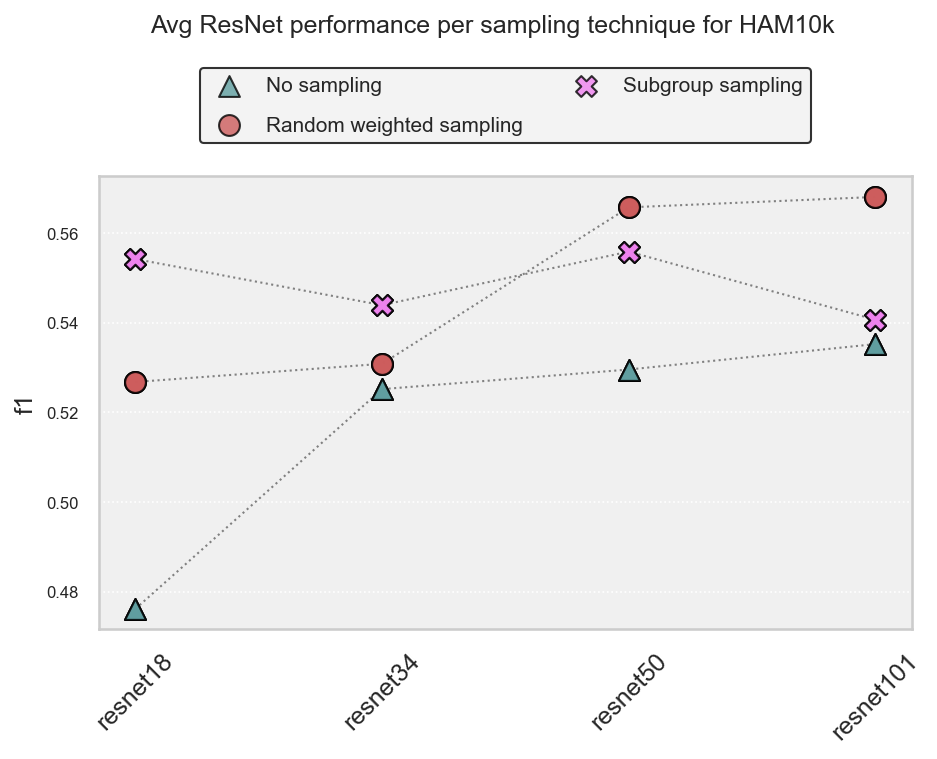

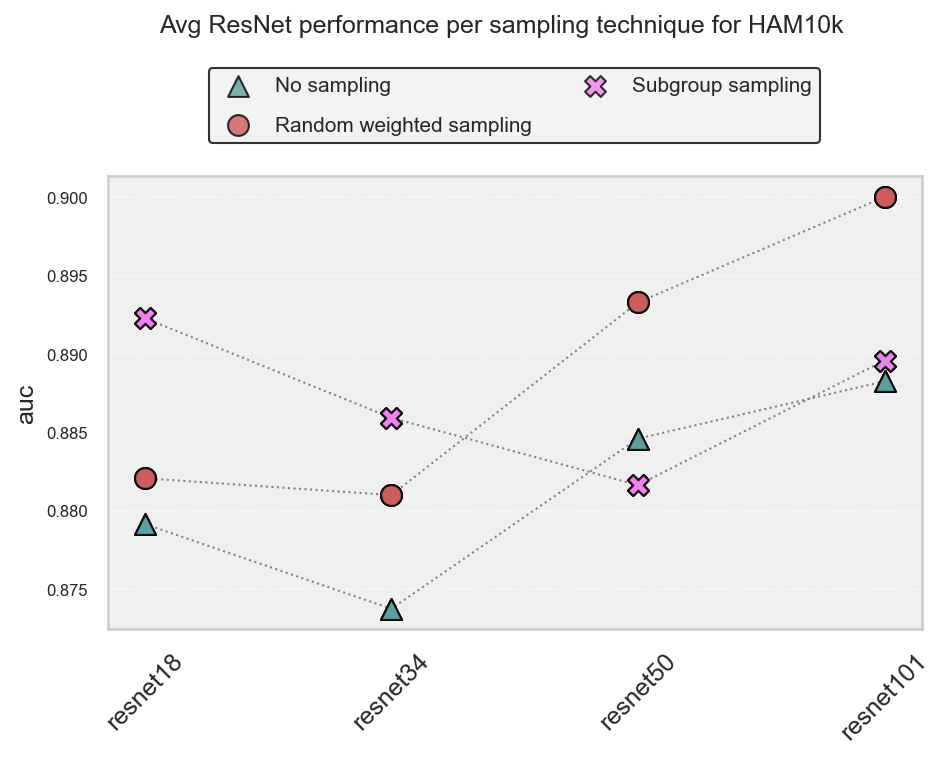

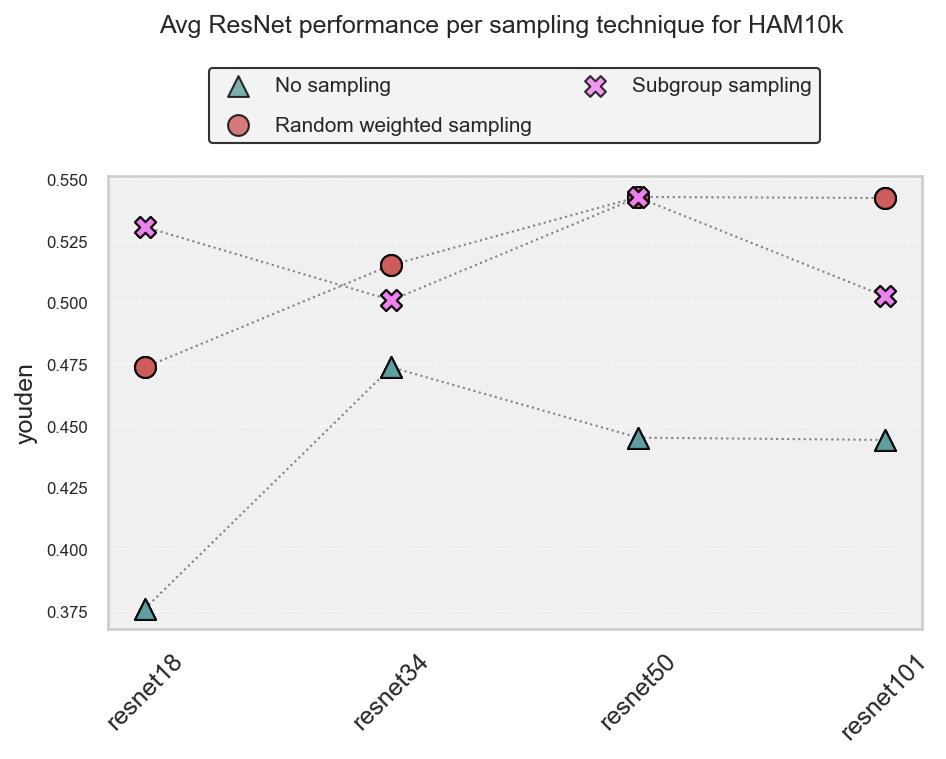

In [248]:
plot_resnet_per_sampling_performance(df=resnet_test_df, metric='f1')
plot_resnet_per_sampling_performance(df=resnet_test_df, metric='auc')
plot_resnet_per_sampling_performance(df=resnet_test_df, metric='youden')

In [6]:
def plot_resnet_per_sampling_performance_grouped_bar_plot(
    df: pd.DataFrame,
    metric: str,
    labels: list[str] = [
        'No sampling',
        'Random weighted sampling',
        'Subgroup sampling'
    ],
    title: str = 'Avg ResNet performance per sampling technique for HAM10k'
):
    sns.set(font_scale=1.2)
    sns.set_style("whitegrid")

    g = sns.catplot(
        data=df, kind="bar",
        x="model_name", y=metric, hue="sampling_technique", estimator=np.mean, 
        errorbar=("pi", 100), height=5, aspect=1.5, capsize=0.05, errwidth=1.2,
    )
    g._legend.remove()
    #  Set axis below
    g.ax.set_axisbelow(True)

    # Set the custom y-scale
    min_val = df[metric].min()
    max_val = df[metric].max()
    plt.ylim(min_val - 0.05 * abs(min_val), max_val + 0.05 * abs(max_val))

    # Add horizontal grid lines and make them dotted
    g.ax.yaxis.grid(True, linestyle='dotted')
    
    # Add border
    g.ax.spines['top'].set_visible(True)
    g.ax.spines['right'].set_visible(True)

    handles, _ = g.ax.get_legend_handles_labels()
    legend = plt.legend(handles, labels, title='Sample Techniques', handlelength=1.5)
    # plt.legend(title='Sample\nTechniques', labels=labels)

    # Set titles
    plt.xlabel('')
    plt.title(title)

    # Move the legend outside and adjust its position
    # plt.tight_layout()  # Ensures the plot and legend do not overlap
    legend.set_bbox_to_anchor((1.02, 0.5))  # Adjust the coordinates for desired positioning

    plt.rcParams['figure.dpi'] = 100
    plt.show()

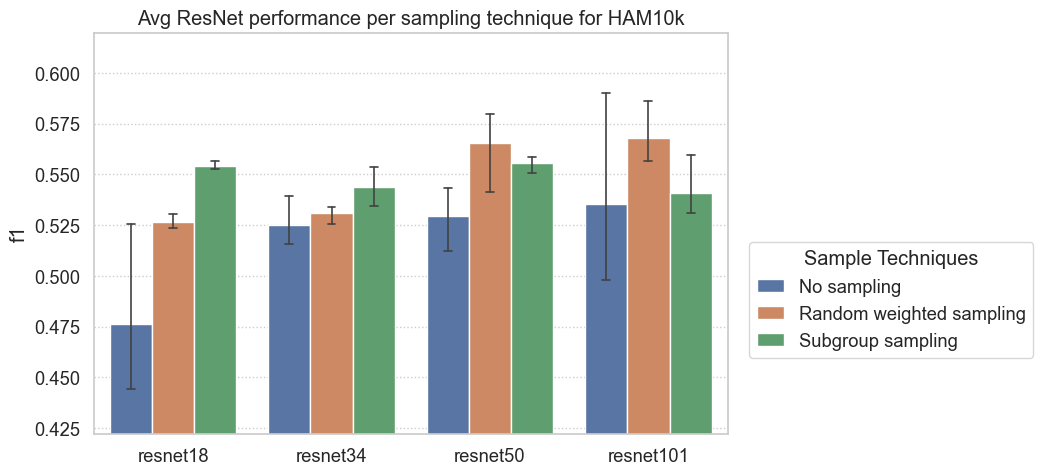

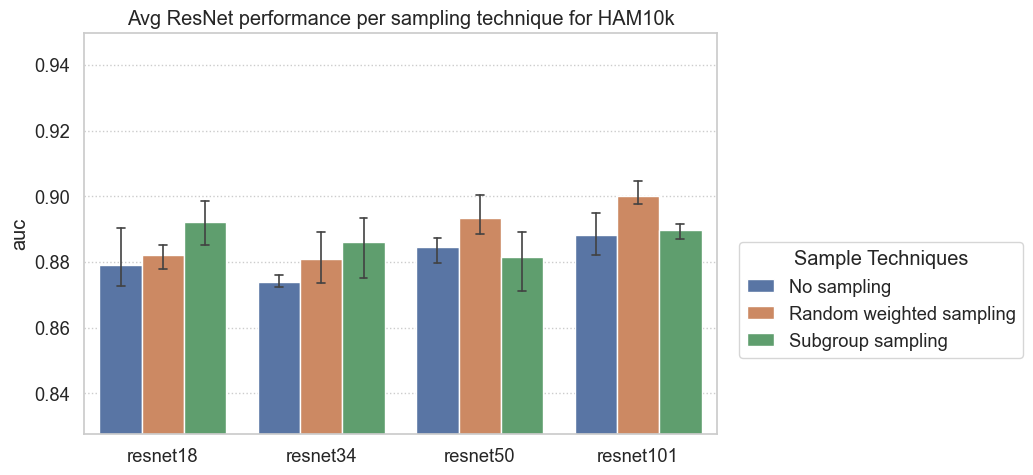

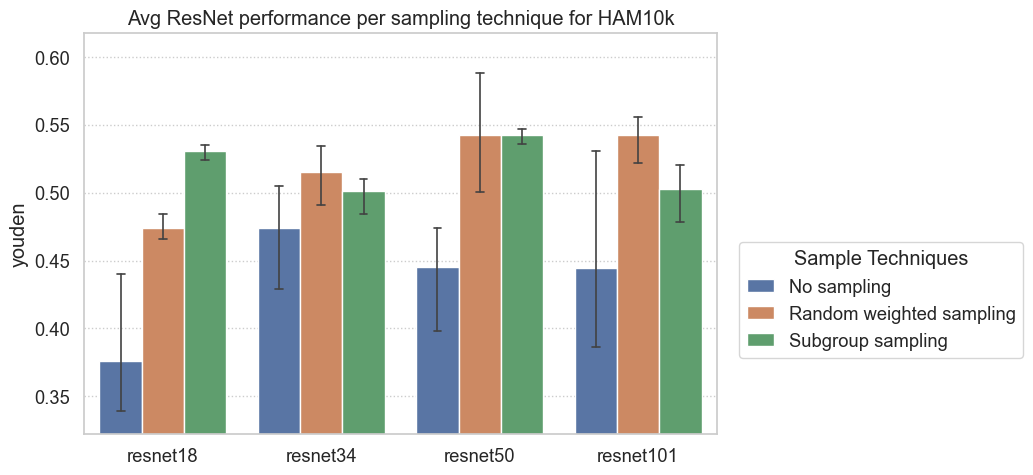

In [8]:
plot_resnet_per_sampling_performance_grouped_bar_plot(resnet_test_df, 'f1')
plot_resnet_per_sampling_performance_grouped_bar_plot(resnet_test_df, 'auc')
plot_resnet_per_sampling_performance_grouped_bar_plot(resnet_test_df, 'youden')

### Individual Model Performance -> Finding Good Teacher Models

In [17]:
def plot_individual_model_performance(
    df: pd.DataFrame,
    metric_1: str,
    metric_2: str,
    labels: list[str] = [
        'No sampling',
        'Random weighted sampling',
        'Subgroup sampling'
    ],
    title: str = 'ResNet models performance per sampling technique for HAM10k'
):
    df['model_name'] = pd.Categorical(df['model_name'], ["resnet18", "resnet34", "resnet50", "resnet101"])
    df = df.sort_values("model_name")
    plt.rcParams['figure.dpi'] = 200
    ax = sns.scatterplot(data=df, x=metric_1, y=metric_2, hue="model_name", style='sampling_technique', palette="deep")
    legend = plt.legend(
        loc='center left',
        bbox_to_anchor=(1, 0.5),
        frameon=True,
        ncol=2,
        columnspacing=0.2,
    )

    # Set the titles and the labels
    legend.get_texts()[0].set_text('Model')
    legend.get_texts()[5].set_text('Sampling')
    legend.get_texts()[6].set_text('None')
    legend.get_texts()[7].set_text('Weighted Random')
    legend.get_texts()[8].set_text('Subgroup')

    ax.set_xlabel(metric_1, fontsize=14)
    ax.set_ylabel(metric_2, fontsize=14)
    ax.set_title(title, fontsize=14)

    ax.grid(linestyle='dotted')

    plt.show()

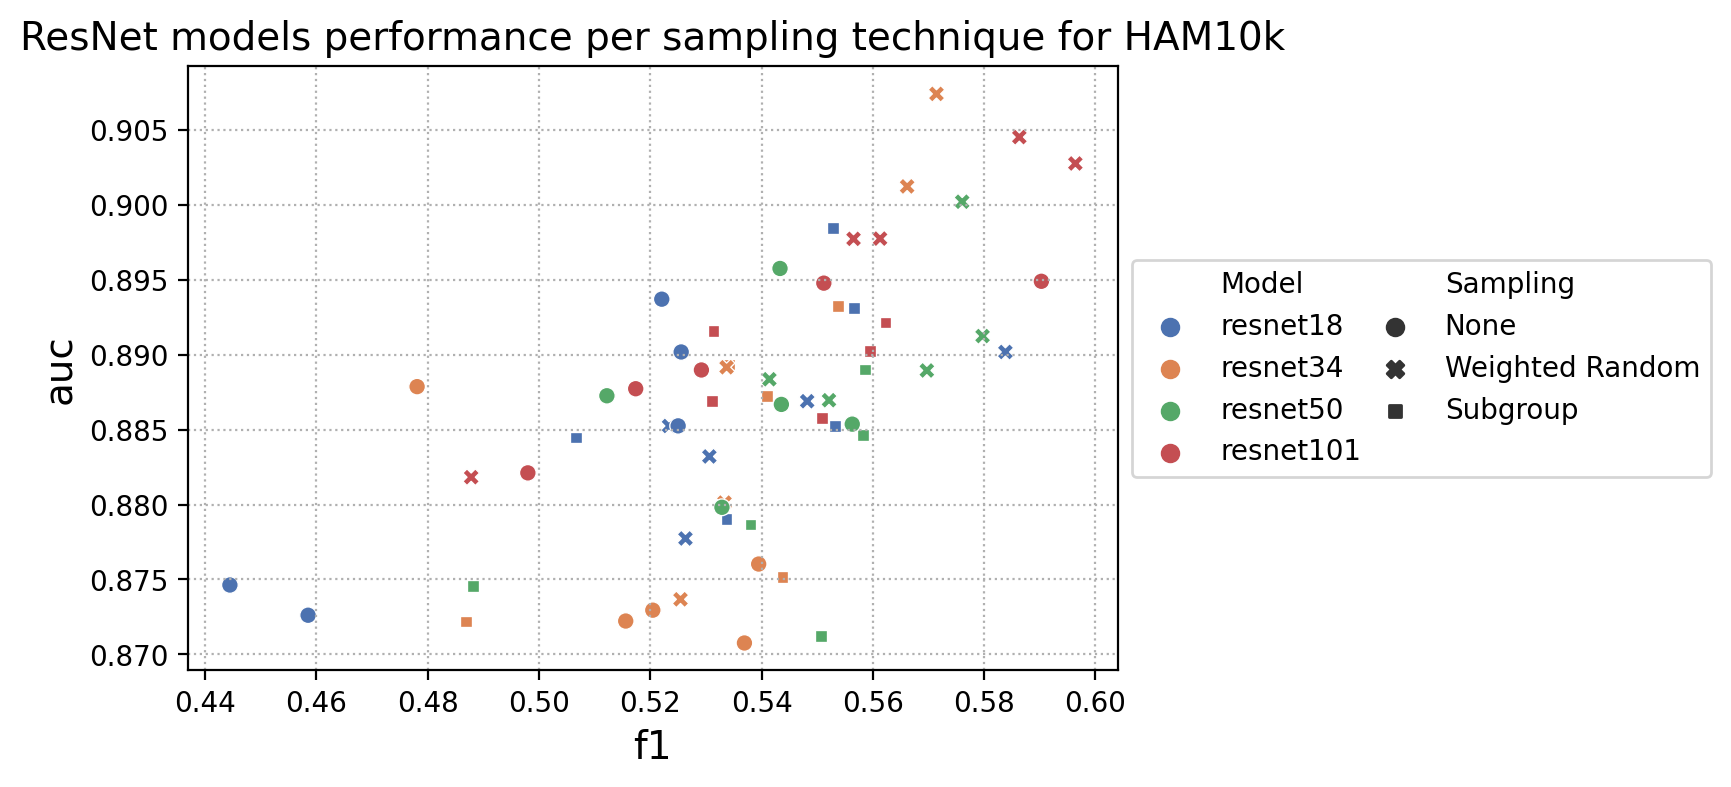

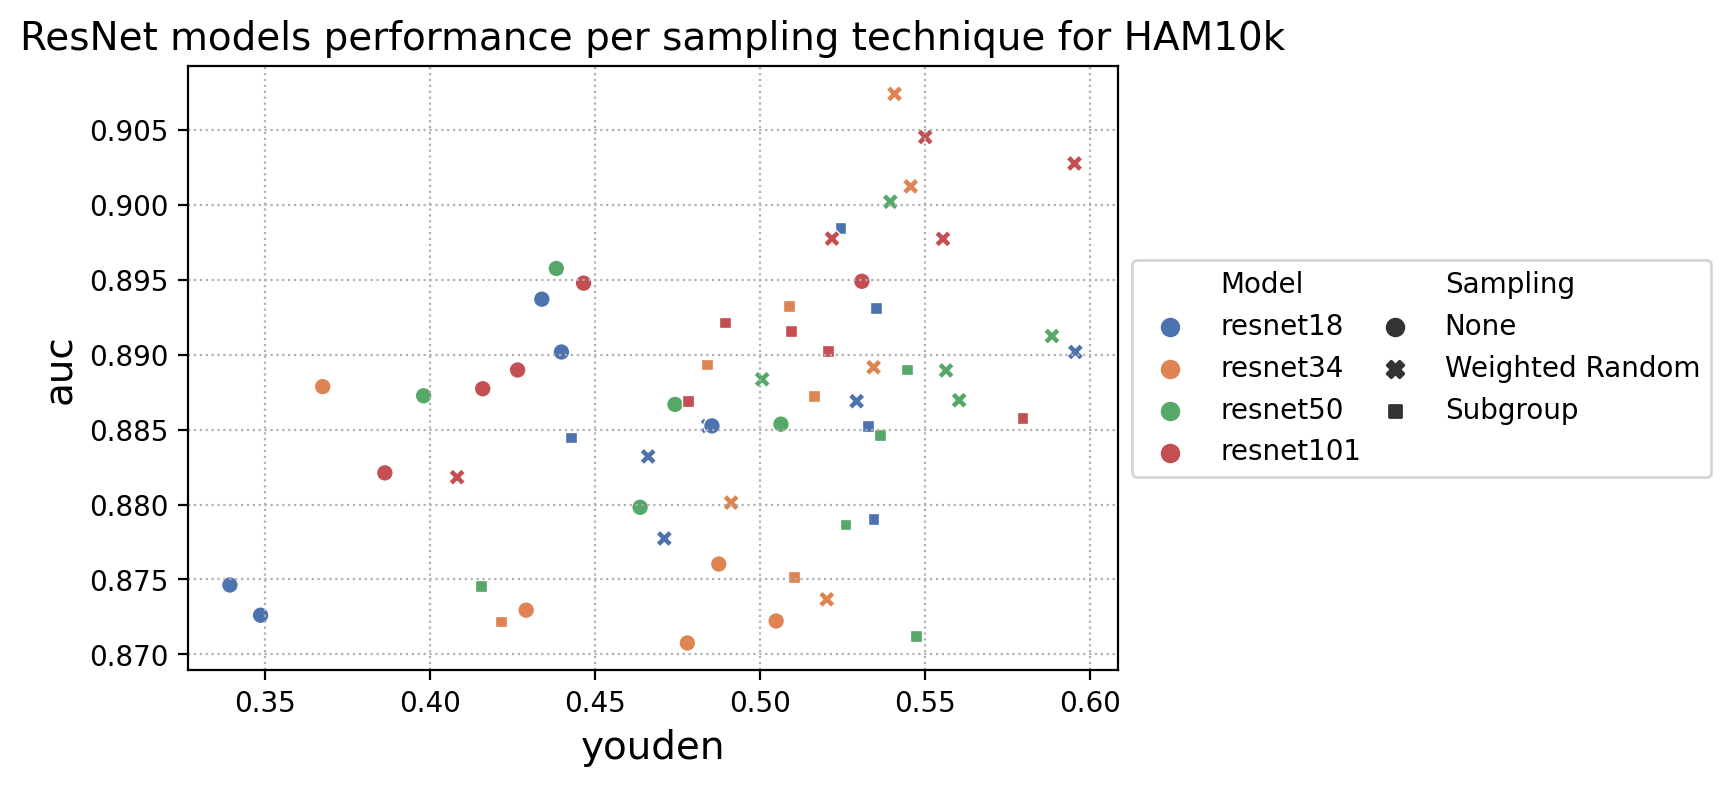

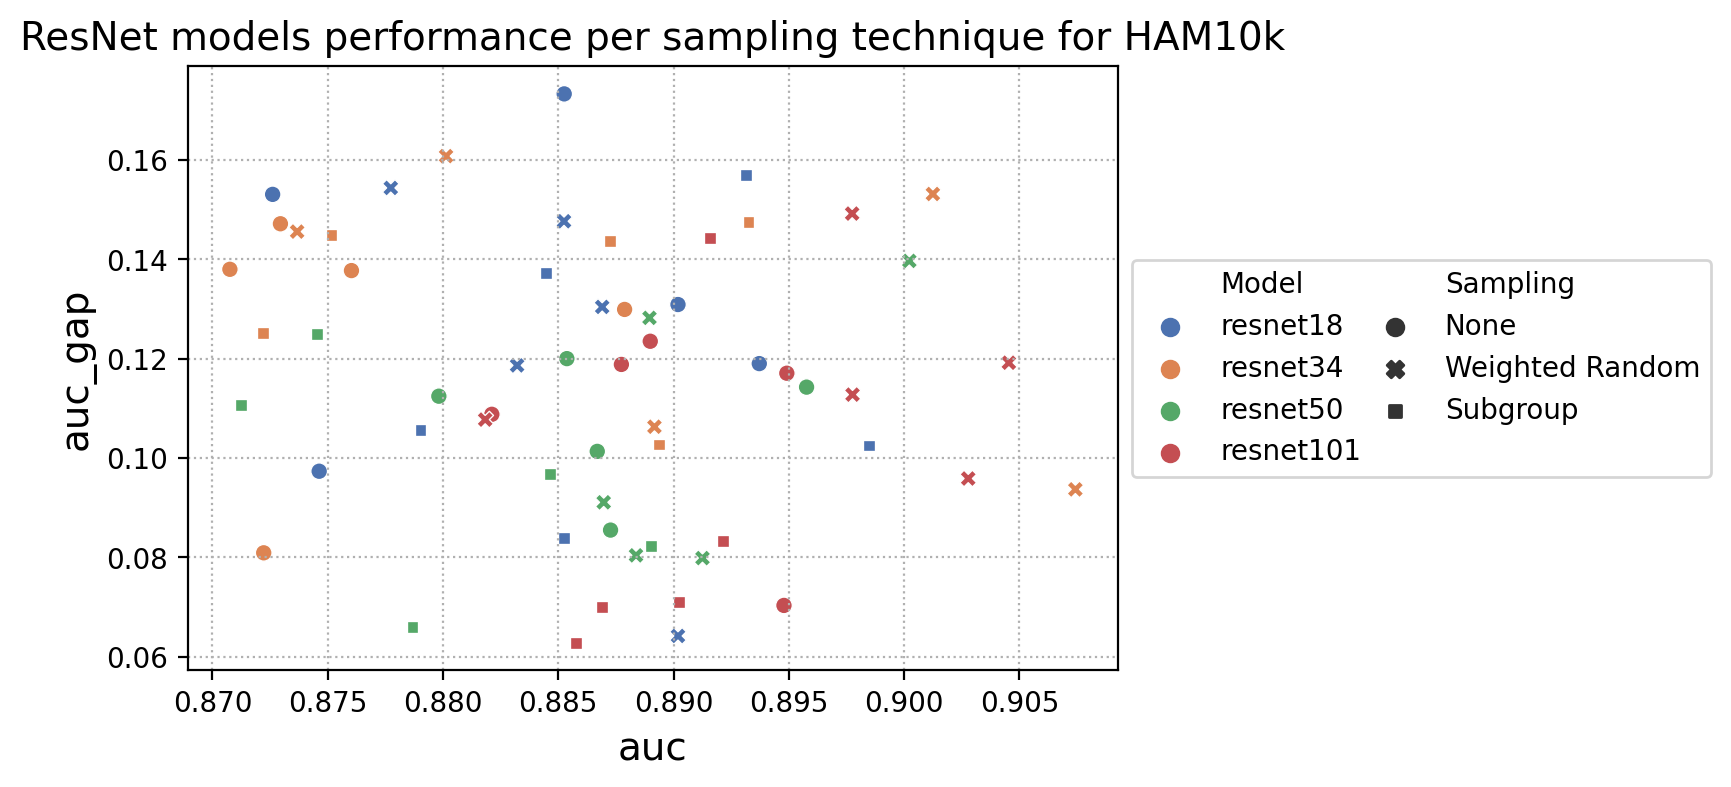

In [18]:

# tmp_resnet_df = resnet_test_df.copy()
# tmp_resnet_df['avg_auc'] = tmp_resnet_df[['age_auc_group_0', 'age_auc_group_1', 'sex_auc_group_0', 'sex_auc_group_1']].mean(axis=1)
# tmp_resnet_df['age_auc_group_0_change'] = tmp_resnet_df['age_auc_group_0'] - tmp_resnet_df['avg_auc']
# tmp_resnet_df['age_auc_group_1_change'] = tmp_resnet_df['age_auc_group_1'] - tmp_resnet_df['avg_auc']
# tmp_resnet_df['sex_auc_group_0_change'] = tmp_resnet_df['sex_auc_group_0'] - tmp_resnet_df['avg_auc']
# tmp_resnet_df['sex_auc_group_1_change'] = tmp_resnet_df['sex_auc_group_1'] - tmp_resnet_df['avg_auc']
# tmp_resnet_df['auc_change_sum'] = abs(tmp_resnet_df['age_auc_group_0_change']) + abs(tmp_resnet_df['age_auc_group_1_change']) + abs(tmp_resnet_df['sex_auc_group_0_change']) + abs(tmp_resnet_df['sex_auc_group_1_change'])

# tmp_df = resnet_test_df[resnet_test_df['sampling_technique'] == 1]

plot_individual_model_performance(resnet_test_df, 'f1', 'auc')
plot_individual_model_performance(resnet_test_df, 'youden', 'auc')
plot_individual_model_performance(resnet_test_df, 'auc', 'auc_gap')
# plot_individual_model_performance(tmp_df, 'auc', 'auc_gap')

### Teacher Performance Analysis

In [ ]:
def plot_teacher_performance(
    df: pd.DataFrame,
    metric: str,
    teacher_ids: list[str],
    teacher_names: dict[str, str],
    title: str = ''
):
    sns.set(font_scale=1.2)
    sns.set_style("whitegrid")

    # Filter the df to only include the models we want
    df = df[df['model_id'].isin(teacher_ids)]
    
    # Plot
    ax = sns.barplot(data=df, x=pd.Categorical(df["model_id"], categories=teacher_ids), y=metric)
    
    ax.set_axisbelow(True)

    # Set the custom y-scale
    min_val = df[metric].min()
    max_val = df[metric].max()
    plt.ylim(min_val - 0.05 * abs(min_val), max_val + 0.05 * abs(max_val))

    # Add horizontal grid lines and make them dotted
    ax.yaxis.grid(True, linestyle='dotted')
    
    # Add border
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)

    # Set x-axis labels
    ax.set_xticklabels([teacher_names.get(tid, tid) for tid in teacher_ids])

    # Set titles
    plt.xlabel('')
    plt.ylabel(metric)
    plt.title(title)

    plt.rcParams['figure.dpi'] = 100
    plt.show()

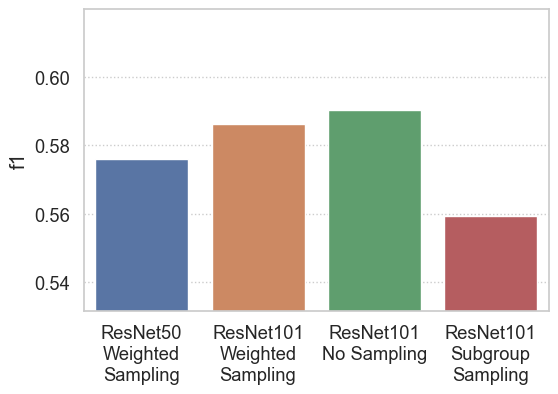

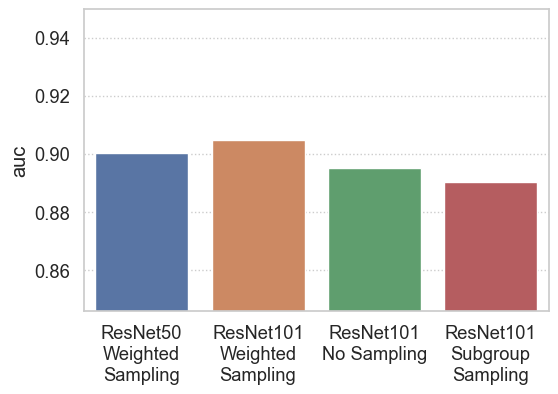

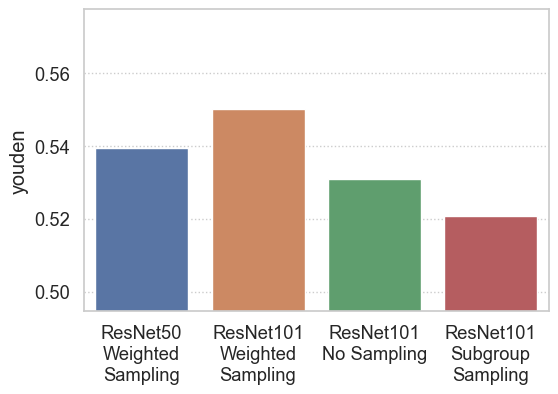

In [201]:
TEACHER_IDS = [
    'r50-sam1-s44',
    'r101-sam1-s43',
    'r101-sam0-s43',
    'r101-sam2-s42',
]

TEACHER_NAMES = {
    'r101-sam1-s43': 'ResNet101\nWeighted\nSampling',
    'r101-sam0-s43': 'ResNet101\nNo Sampling',
    'r50-sam1-s44': 'ResNet50\nWeighted\nSampling',
    'r101-sam2-s42': 'ResNet101\nSubgroup\nSampling',
}

for metric in ['f1', 'auc', 'youden']:
    plot_teacher_performance(
        df=resnet_test_df,
        metric=metric,
        teacher_ids=TEACHER_IDS,
        teacher_names=TEACHER_NAMES,
    )

## Fairness Analysis

### Resnet sampling fairness comparison for subgroups

In [262]:
def plot_resnet_per_sampling_subgroup_performance(
    df: pd.DataFrame,
    metric: str,
    model_names: list[str],
    labels: list[str] = [
        'None',
        'Random weighted',
        'Subgroup'
    ],
    title: str = 'Avg ResNet subgroup performance per sampling technique for HAM10k'
):
    sns.set(font_scale=1.2)
    sns.set_style("whitegrid")

    # Specify the subgroup metrics for this dataset
    subgroup_metrics = [f'age_{metric}_group_0', f'age_{metric}_group_1', f'sex_{metric}_group_0', f'sex_{metric}_group_1']
    subgroup_metrics_names = {
        f'age_{metric}_group_0': 'Age < 60',
        f'age_{metric}_group_1': 'Age 60+',
        f'sex_{metric}_group_0': 'Male',
        f'sex_{metric}_group_1': 'Female',
    }

    # Filter the df to only include the models we want
    df = df[df['model_name'].isin(model_names)]
    df = df[subgroup_metrics + ['sampling_technique']]
    df = df.melt('sampling_technique', var_name='metric', value_name='value')

    # Plot

    g = sns.catplot(
        data=df, kind="bar",
        x="metric", y='value', hue="sampling_technique", estimator=np.mean, 
        errorbar=("pi", 100), height=5, aspect=1.5, capsize=0.05, errwidth=1.2,
    )
    g._legend.remove()
    
    g.ax.set_axisbelow(True)

    # # Set the custom y-scale
    min_val = df['value'].min()
    max_val = df['value'].max()
    plt.ylim(min_val - 0.05 * abs(min_val), max_val + 0.05 * abs(max_val))

    # Add horizontal grid lines and make them dotted
    g.ax.yaxis.grid(True, linestyle='dotted')
    
    # Add border
    g.ax.spines['top'].set_visible(True)
    g.ax.spines['right'].set_visible(True)

    handles, _ = g.ax.get_legend_handles_labels()
    # legend = plt.legend(handles, labels, title='Sample Techniques', handlelength=1.5)

    x_labels = [subgroup_metrics_names.get(metric, metric) for metric in df['metric'].unique()]
    g.ax.set_xticklabels(x_labels)

    # # Set titles
    plt.xlabel('')
    plt.ylabel(metric) # TODO: add metric name
    plt.title(title)

    # # Move the legend outside and adjust its position
    # # plt.tight_layout()  # Ensures the plot and legend do not overlap
    # legend.set_bbox_to_anchor((1.02, 0.5))  # Adjust the coordinates for desired positioning

    plt.rcParams['figure.dpi'] = 100
    plt.show()

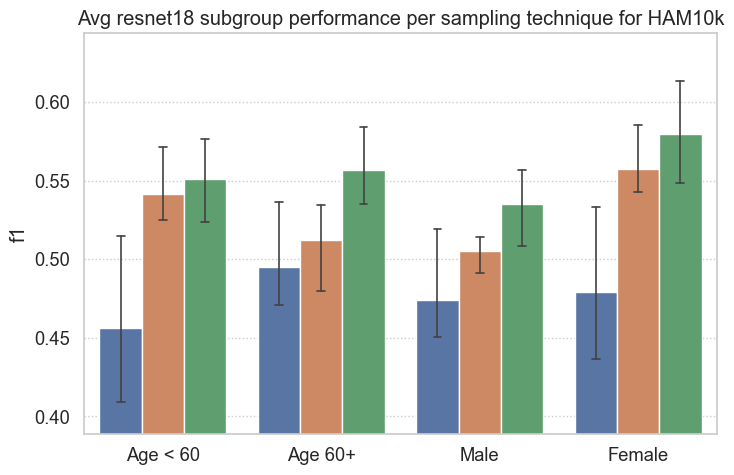

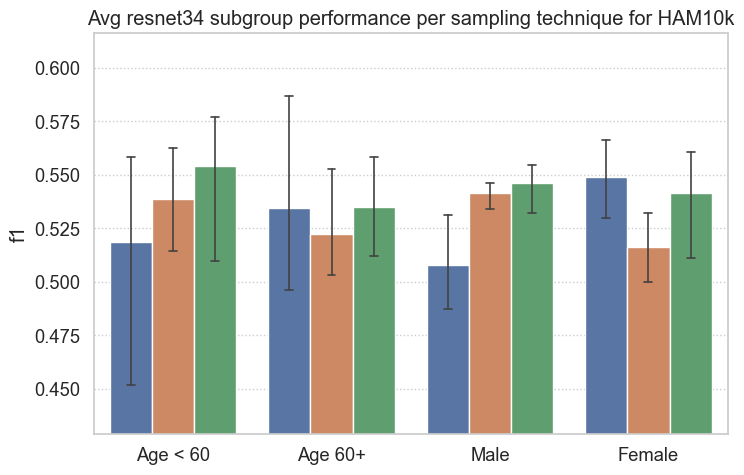

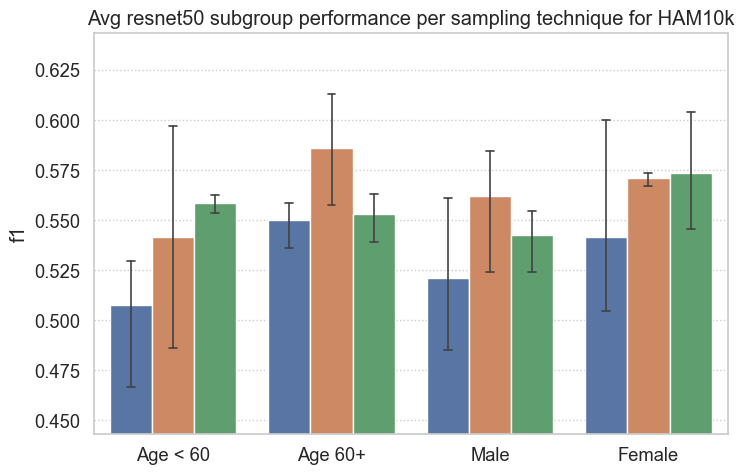

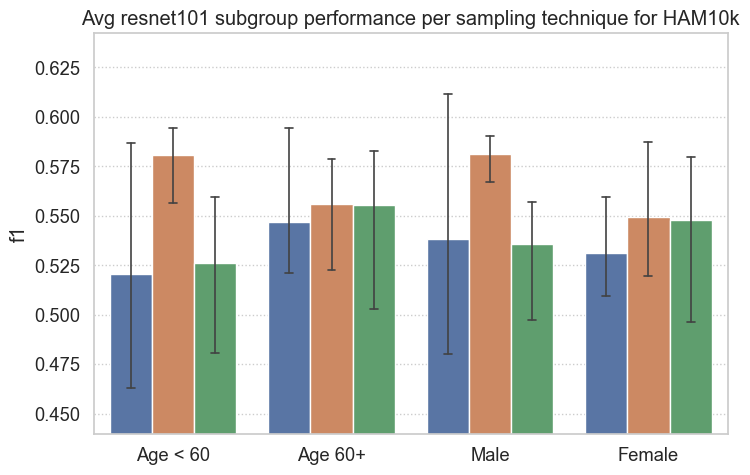

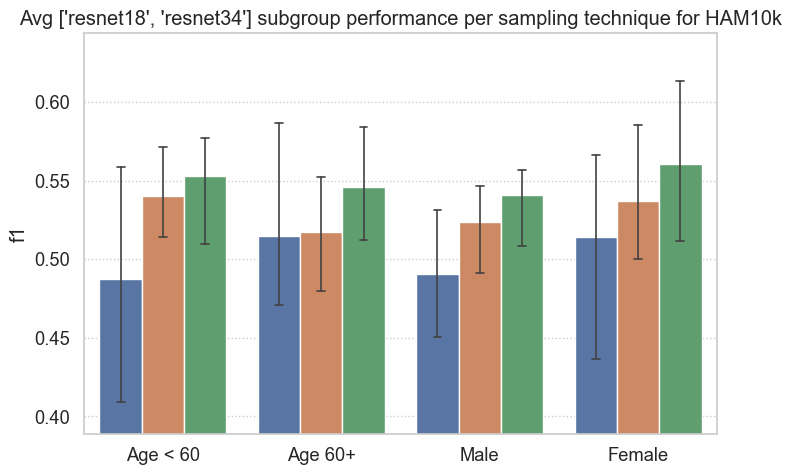

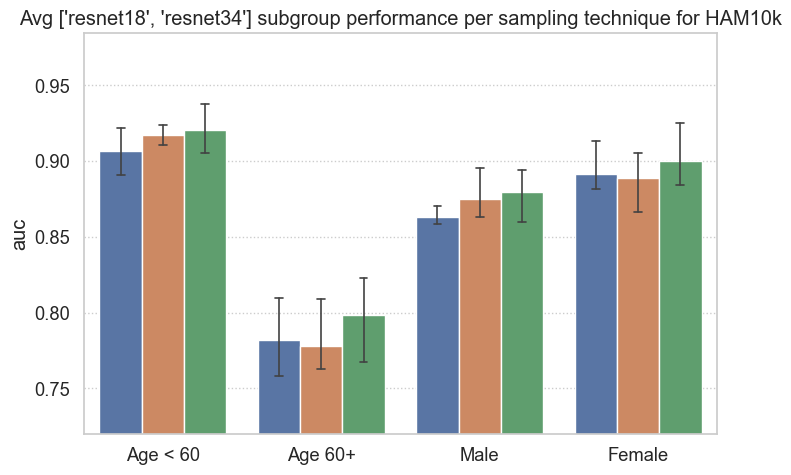

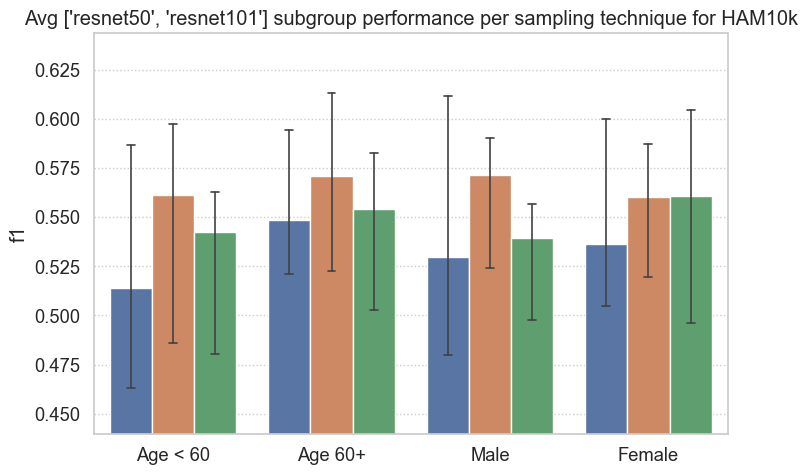

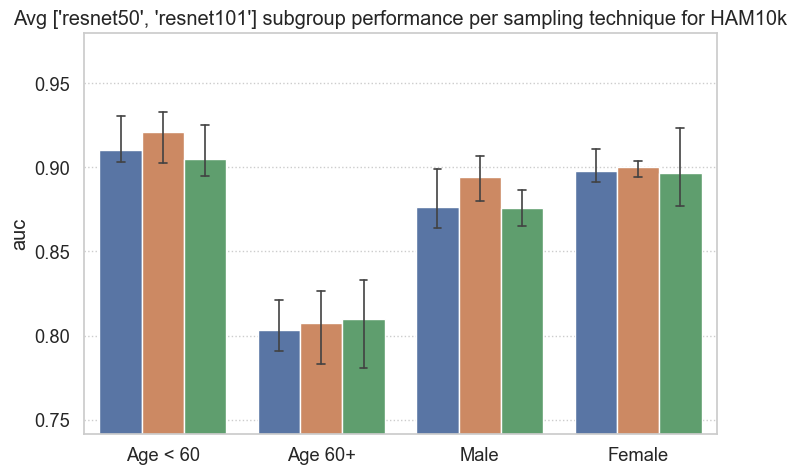

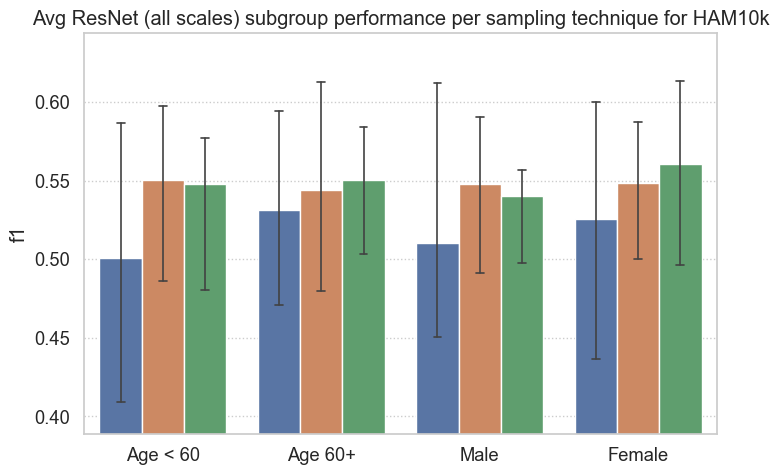

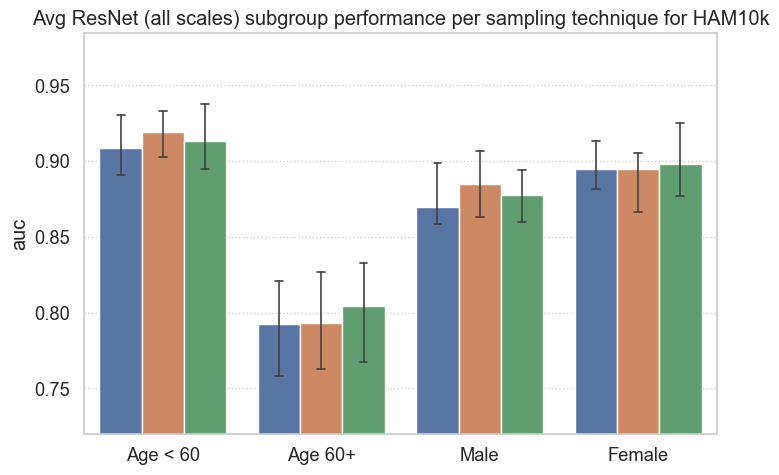

In [263]:
# FOR EACH RESNET SCALE SEPRERTELY:
models = ['resnet18', 'resnet34', 'resnet50', 'resnet101']
for model in models:
    plot_resnet_per_sampling_subgroup_performance(
        resnet_test_df, 
        'f1', 
        [model],
        title=f'Avg {model} subgroup performance per sampling technique for HAM10k'
    )

# FOR TEACHER SCALES AND STUDENT SCALES
for model_pair in [['resnet18', 'resnet34'], ['resnet50', 'resnet101']]:
    for metric in ['f1', 'auc']:
        plot_resnet_per_sampling_subgroup_performance(
            resnet_test_df, 
            metric,
            model_pair,
            title=f'Avg {model_pair} subgroup performance per sampling technique for HAM10k'
        )

# FOR ALL RESNETS
plot_resnet_per_sampling_subgroup_performance(
    resnet_test_df, 
    'f1', 
    models,
    title='Avg ResNet (all scales) subgroup performance per sampling technique for HAM10k'
)
plot_resnet_per_sampling_subgroup_performance(
    resnet_test_df, 
    'auc', 
    models,
    title='Avg ResNet (all scales) subgroup performance per sampling technique for HAM10k'
)

### ResNet fairness comparison for different scales

In [74]:
def plot_resnet_per_scale_subgroup_performance(
    df: pd.DataFrame,
    metric: str,
    sampling_technique: int,
    labels: list[str] = [
        'ResNet18',
        'ResNet34',
        'ResNet50',
        'ResNet101'
    ],
    title: str = ''
):
    sns.set(font_scale=1.2)
    sns.set_style("whitegrid")

    # Specify the subgroup metrics for this dataset
    subgroup_metrics = [f'age_{metric}_group_0', f'age_{metric}_group_1', f'sex_{metric}_group_0', f'sex_{metric}_group_1']
    subgroup_metrics_names = {
        f'age_{metric}_group_0': 'Age < 60',
        f'age_{metric}_group_1': 'Age 60+',
        f'sex_{metric}_group_0': 'Male',
        f'sex_{metric}_group_1': 'Female',
    }

    # Filter the df to only include the models we want
    df = df[df['sampling_technique'] == sampling_technique]
    df = df[subgroup_metrics + ['model_name']]
    df = df.melt('model_name', var_name='metric', value_name='value')

    df.to_csv('lol.csv')

    # Plot
    g = sns.catplot(
        data=df, kind="bar",
        x="metric", y='value', hue="model_name", estimator=np.mean, 
        errorbar=("pi", 100), height=5, aspect=1.5, capsize=0.05, errwidth=1.2,
    )
    g._legend.remove()
    
    g.ax.set_axisbelow(True)

    # # Set the custom y-scale
    min_val = df['value'].min()
    max_val = df['value'].max()
    plt.ylim(min_val - 0.05 * abs(min_val), max_val + 0.05 * abs(max_val))

    # Add horizontal grid lines and make them dotted
    g.ax.yaxis.grid(True, linestyle='dotted')
    
    # Add border
    g.ax.spines['top'].set_visible(True)
    g.ax.spines['right'].set_visible(True)

    handles, _ = g.ax.get_legend_handles_labels()
    legend = plt.legend(handles, labels, title='Model', handlelength=1.5)

    x_labels = [subgroup_metrics_names.get(metric, metric) for metric in df['metric'].unique()]
    g.ax.set_xticklabels(x_labels)

    # # Set titles
    plt.xlabel('')
    plt.ylabel(metric) # TODO: add metric name
    plt.title(title)

    # # Move the legend outside and adjust its position
    # # plt.tight_layout()  # Ensures the plot and legend do not overlap
    legend.set_bbox_to_anchor((1.02, 0.5))  # Adjust the coordinates for desired positioning

    plt.rcParams['figure.dpi'] = 100
    plt.show()

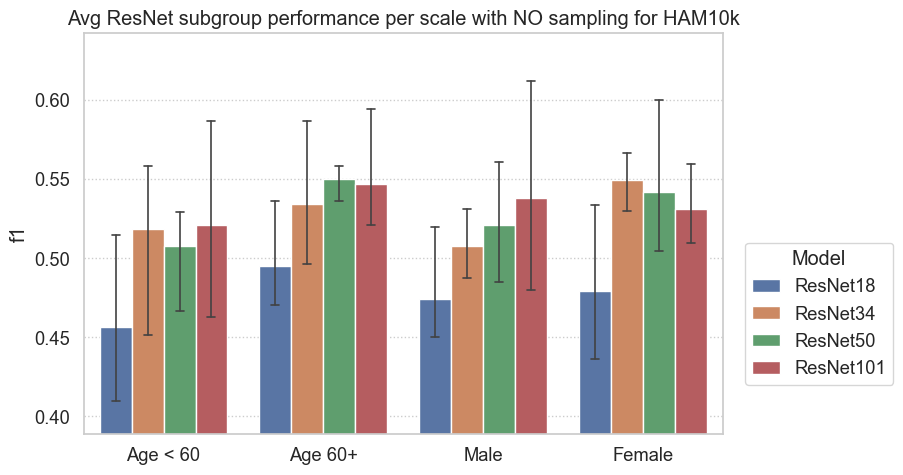

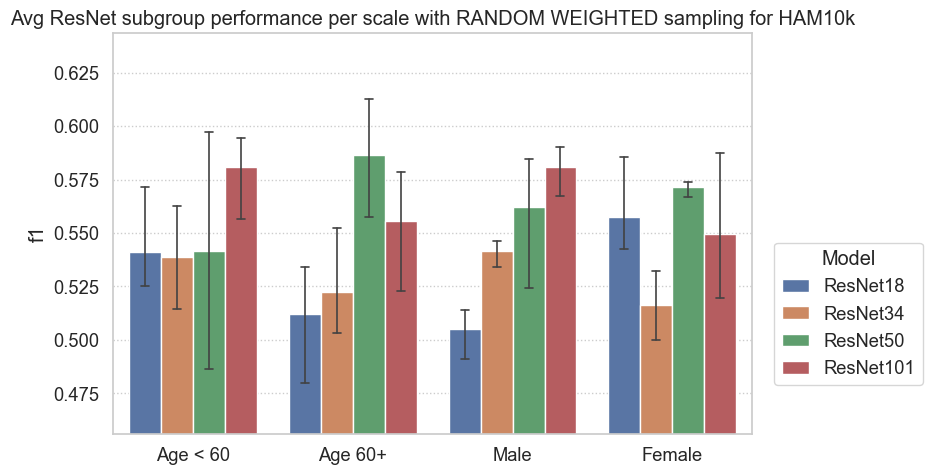

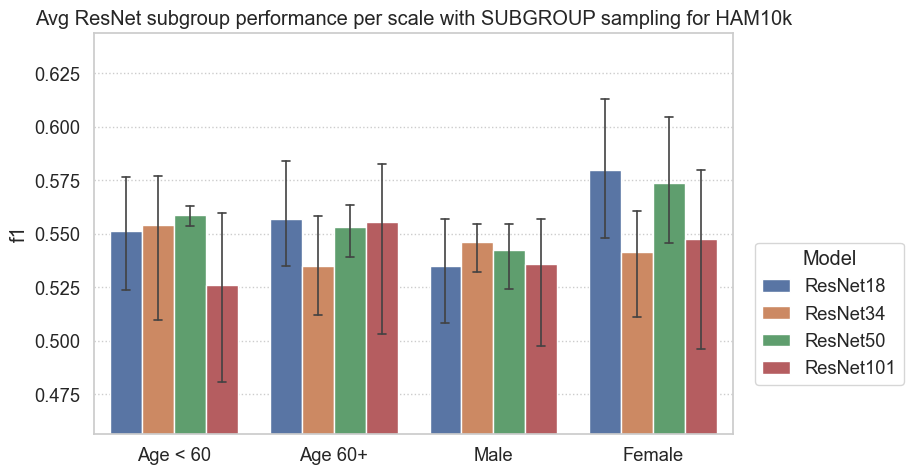

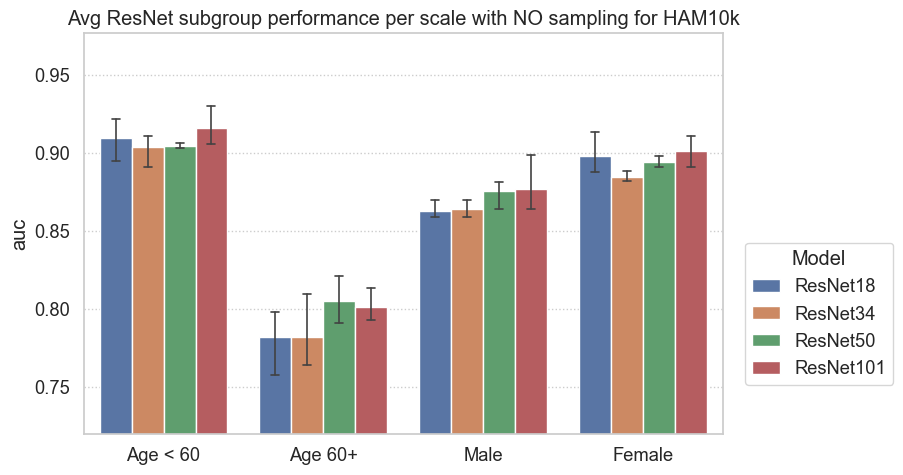

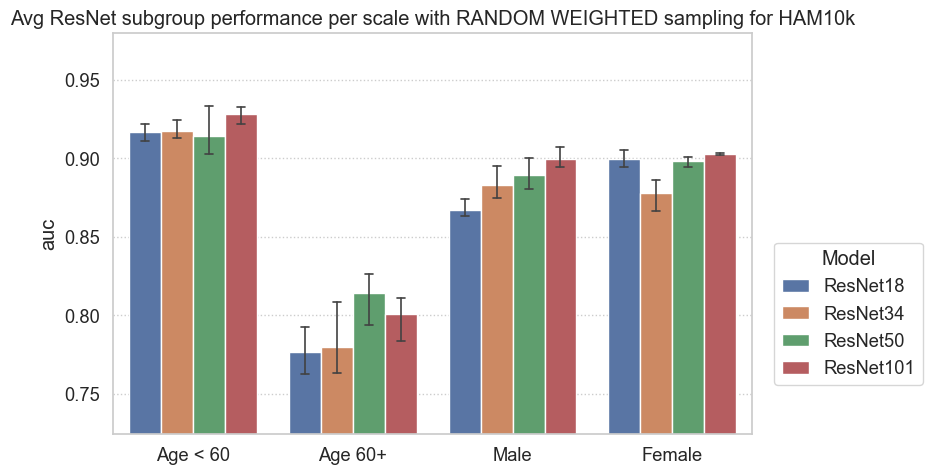

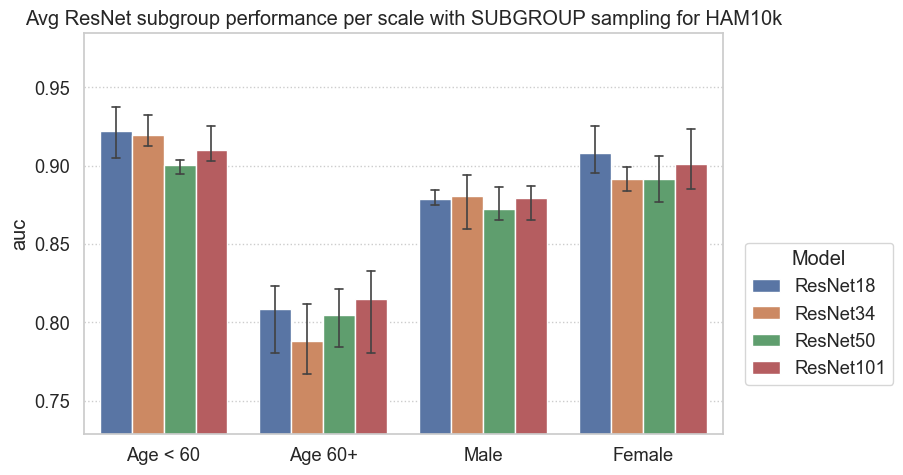

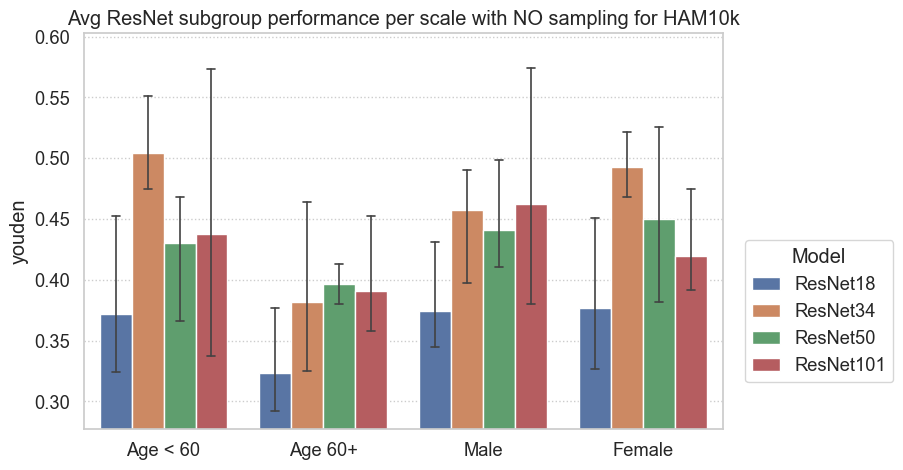

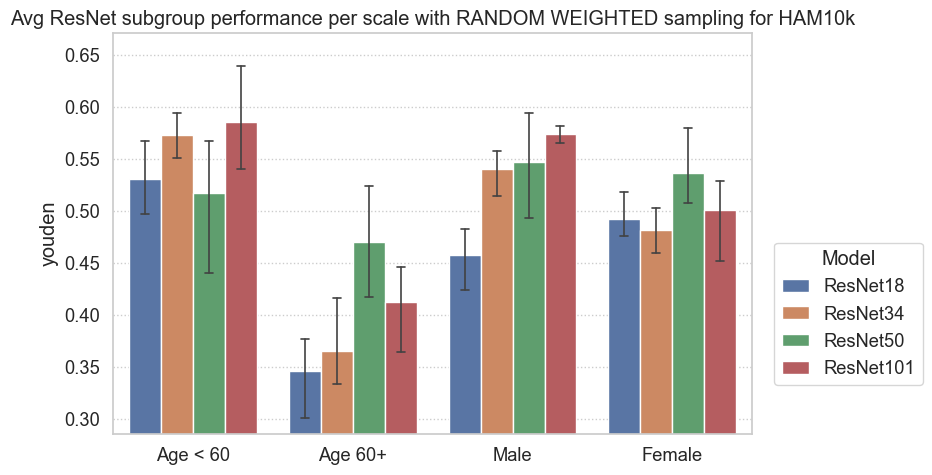

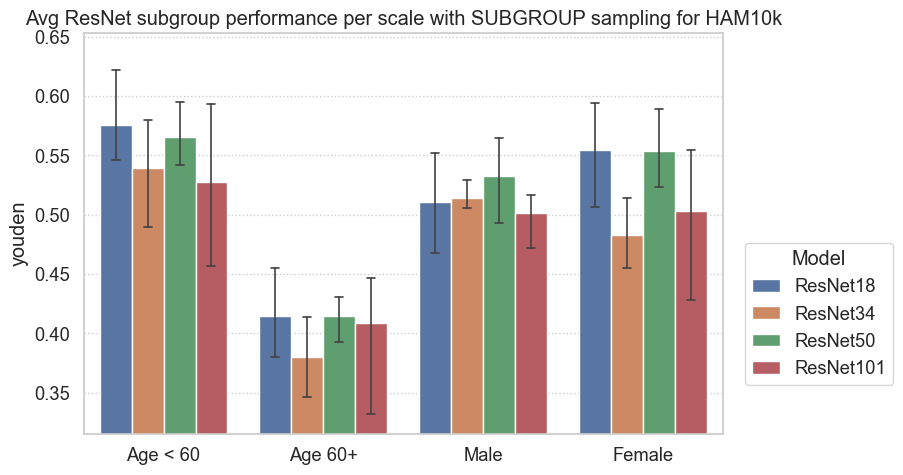

In [76]:
for metric in ['f1', 'auc', 'youden']:
    for sampling_technique in [0, 1, 2]:
        plot_resnet_per_scale_subgroup_performance(
            df=resnet_test_df,
            metric=metric,
            sampling_technique=sampling_technique,
            title=f'Avg ResNet subgroup performance per scale with {SAMPLING_TECHNIQUES_NAMES[sampling_technique]} sampling for HAM10k'
        )

### Overall Unfairness Measurement for each resnet scale and each subgroup sampling

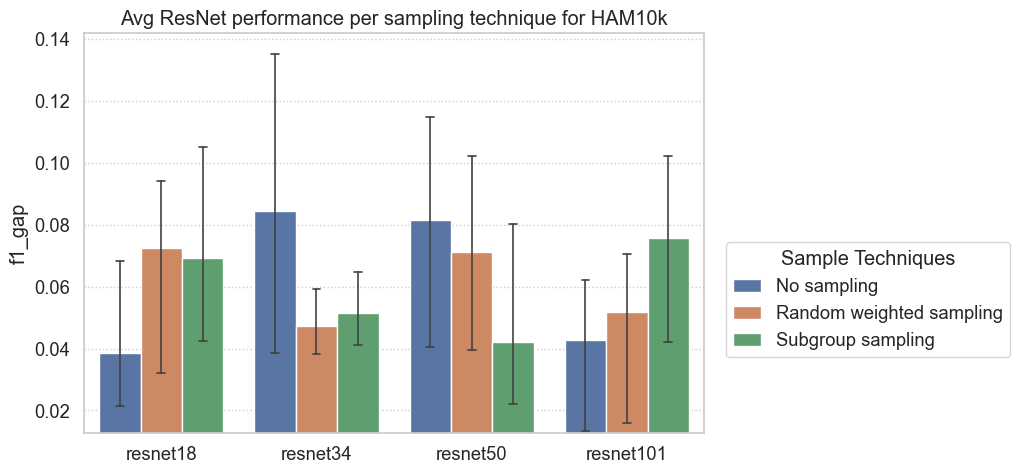

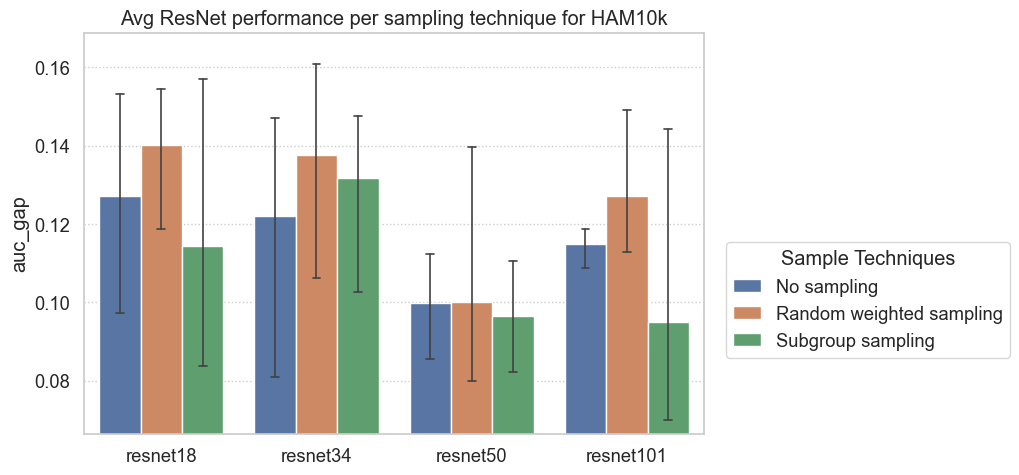

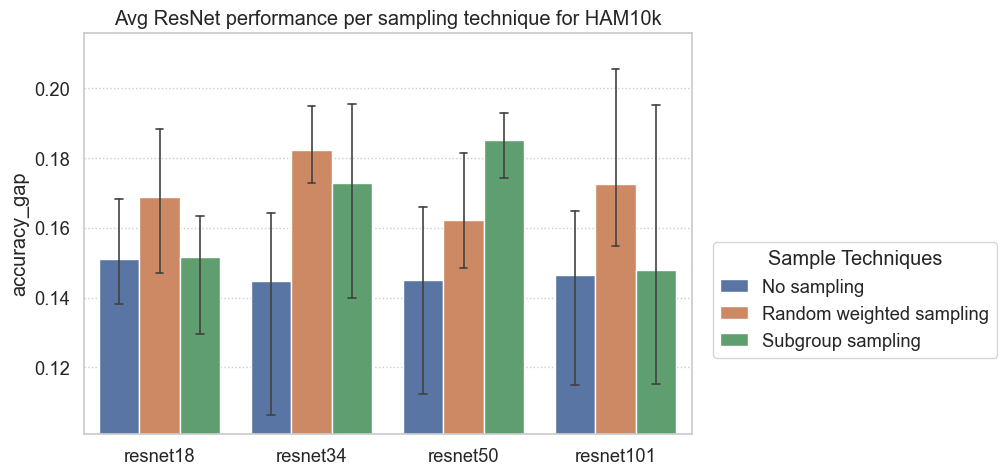

In [103]:
plot_resnet_per_sampling_performance_grouped_bar_plot(resnet_test_df, 'f1_gap')
plot_resnet_per_sampling_performance_grouped_bar_plot(resnet_test_df, 'auc_gap')
plot_resnet_per_sampling_performance_grouped_bar_plot(resnet_test_df, 'accuracy_gap')

TEACHER_IDS = [
    'r50-sam1-s44',
    'r101-sam1-s43',
    'r101-sam0-s43',
    'r101-sam2-s42',
]

TEACHER_NAMES = {
    'r101-sam1-s43': 'ResNet101\nWeighted\nSampling',
    'r101-sam0-s43': 'ResNet101\nNo Sampling',
    'r50-sam1-s44': 'ResNet50\nWeighted\nSampling',
    'r101-sam2-s42': 'ResNet101\nSubgroup\nSampling',
}

plot_teacher_performance(
    df=resnet_test_df,
    metric='f1',
    teacher_ids=TEACHER_IDS,
    teacher_names=TEACHER_NAMES,
)

### ResNet Teachers Comparison

In [198]:
def plot_teacher_performance(
    df: pd.DataFrame,
    metric: str,
    teacher_ids: list[str],
    teacher_names: dict[str, str],
    title: str = ''
):
    sns.set(font_scale=1.2)
    sns.set_style("whitegrid")

    # Specify the subgroup metrics for this dataset
    subgroup_metrics = [f'age_{metric}_group_0', f'age_{metric}_group_1', f'sex_{metric}_group_0', f'sex_{metric}_group_1']
    subgroup_metrics_names = {
        f'age_{metric}_group_0': 'Age < 60',
        f'age_{metric}_group_1': 'Age 60+',
        f'sex_{metric}_group_0': 'Male',
        f'sex_{metric}_group_1': 'Female',
    }

    # Filter the df to only include the models we want
    df = df[df['model_id'].isin(teacher_ids)]
    df = df[subgroup_metrics + ['model_id']]
    df = df.melt('model_id', var_name='metric', value_name='value')

    # Plot
    g = sns.catplot(
        data=df, kind="bar",
        x="metric", y='value', hue="model_id", height=5, aspect=1.5, capsize=0.05
    )
    g._legend.remove()

    g.ax.set_axisbelow(True)

    # Set the custom y-scale
    min_val = df['value'].min()
    max_val = df['value'].max()
    plt.ylim(min_val - 0.05 * abs(min_val), max_val + 0.05 * abs(max_val))

    # Add horizontal grid lines and make them dotted
    g.ax.yaxis.grid(True, linestyle='dotted')
    
    # Add border
    g.ax.spines['top'].set_visible(True)
    g.ax.spines['right'].set_visible(True)

    handles, labels = g.ax.get_legend_handles_labels()
    legend_names = [teacher_names[label] for label in labels]
    legend = plt.legend(handles, legend_names, title='Teacher Model', handlelength=1.5)
    x_labels = [subgroup_metrics_names.get(metric, metric) for metric in df['metric'].unique()]
    g.ax.set_xticklabels(x_labels)

    # # Set titles
    plt.xlabel('')
    plt.ylabel(metric)
    plt.title(title)

    # Move the legend outside and adjust its position
    legend.set_bbox_to_anchor((1.02, 0.8))  # Adjust the coordinates for desired positioning

    plt.rcParams['figure.dpi'] = 100
    plt.show()

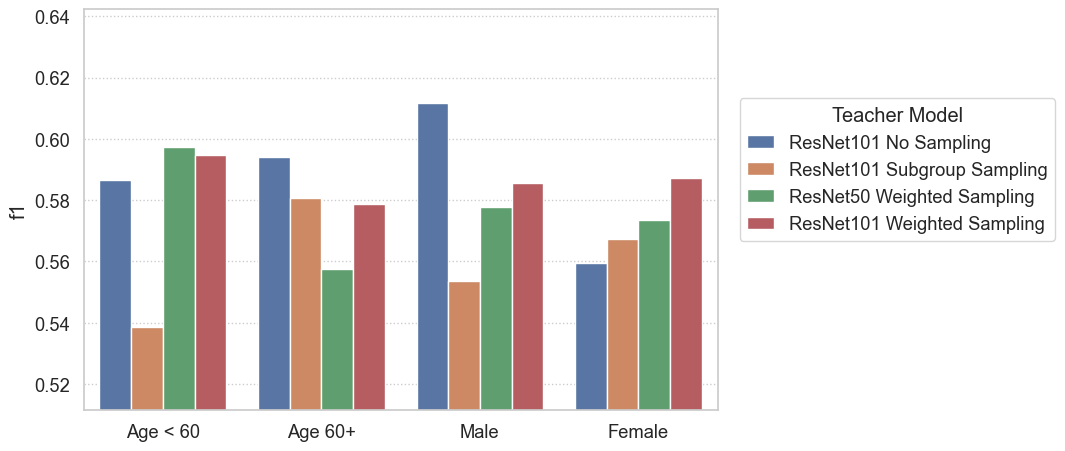

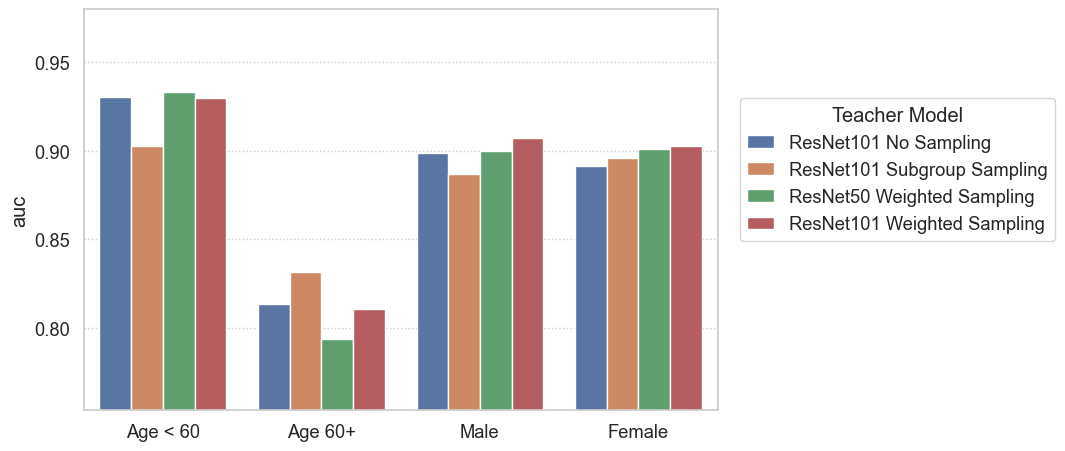

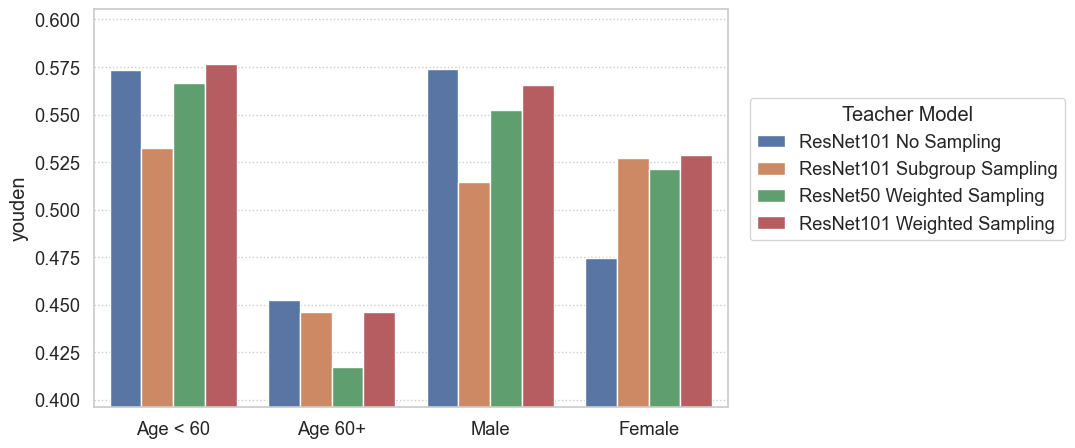

In [199]:
TEACHER_IDS = [
    'r101-sam1-s43',
    'r101-sam0-s43',
    'r50-sam1-s44',
    'r101-sam2-s42',
]

TEACHER_NAMES = {
    'r101-sam1-s43': 'ResNet101 Weighted Sampling',
    'r101-sam0-s43': 'ResNet101 No Sampling',
    'r50-sam1-s44': 'ResNet50 Weighted Sampling',
    'r101-sam2-s42': 'ResNet101 Subgroup Sampling',
}

for metric in ['f1', 'auc', 'youden']:
    plot_teacher_performance(
        df=resnet_test_df,
        metric=metric,
        teacher_ids=TEACHER_IDS,
        teacher_names=TEACHER_NAMES,
    )

### Teacher unfairness comparison

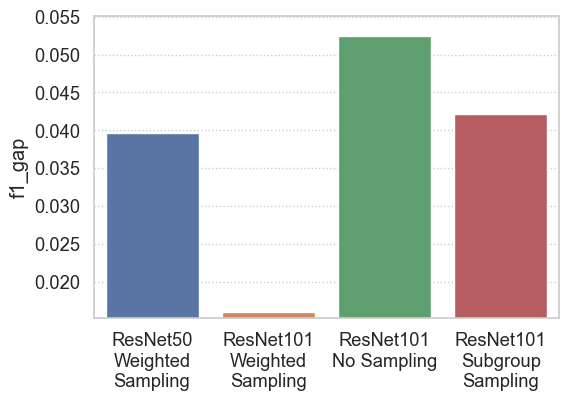

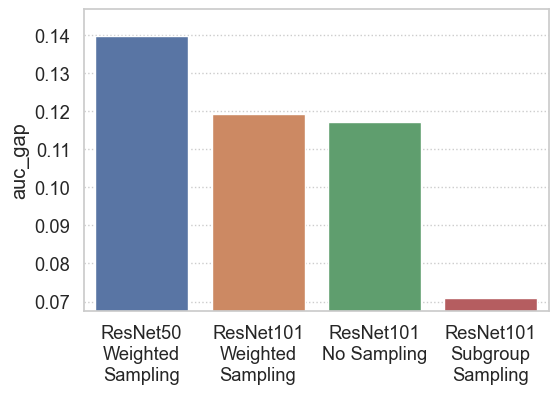

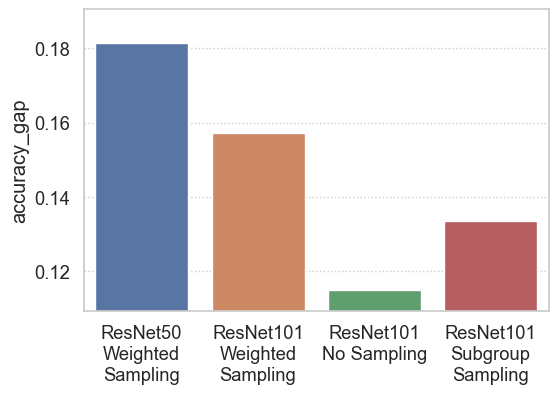

In [203]:
TEACHER_IDS = [
    'r50-sam1-s44',
    'r101-sam1-s43',
    'r101-sam0-s43',
    'r101-sam2-s42',
]

TEACHER_NAMES = {
    'r101-sam1-s43': 'ResNet101\nWeighted\nSampling',
    'r101-sam0-s43': 'ResNet101\nNo Sampling',
    'r50-sam1-s44': 'ResNet50\nWeighted\nSampling',
    'r101-sam2-s42': 'ResNet101\nSubgroup\nSampling',
}

for metric in ['f1_gap', 'auc_gap', 'accuracy_gap']:
    plot_teacher_performance(
        df=resnet_test_df,
        metric=metric,
        teacher_ids=TEACHER_IDS,
        teacher_names=TEACHER_NAMES,
    )

<!-- models = ["resnet18", "resnet34", "resnet50", "resnet101"]
seeds = [42, 43, 44]
sampling_ids = [0, 1] # Without the subgroup sampling for now
results_path = '../results/ham10000/resnet/predictions/'

test_data = []
val_data = []

for model in models:
    for sampling_technique in sampling_ids:
        for seed in seeds:
            res_scale = re.findall(r'\d+', model)[0]
            model_id = "r" + str(res_scale) + "-sam" + str(sampling_technique) + "-s" + str(seed) 
            path = results_path + model_id

            df_tmp = pd.read_csv(path + '/test.csv')
            test_data.append(df_tmp)
            
            df_tmp = pd.read_csv(path + '/val.csv')
            val_data.append(df_tmp)
    
resnet_test_df = pd.concat(test_data)    
resnet_val_df = pd.concat(val_data) -->

## KD Performance Analysis

In [267]:
def plot_kd_performance(
    resnet_df: pd.DataFrame,
    kd_df: pd.DataFrame,
    metric: str,
    teacher_ids: list[str],
    sampling_technique: int,
    student_models = ['resnet18', 'resnet34'],
    title: str = 'Avg ResNet performance per sampling technique for HAM10k',
    connect_markers: bool = False
):  
    plt.rcParams['figure.dpi'] = 150

    # Get teachers from resnet_df

    # KD_DF => just student models that satisfy these conditions:
    kd_df = kd_df[kd_df['teacher_id'].isin(teacher_ids)]
    kd_df = kd_df[kd_df['model_name'].isin(student_models)]
    kd_df = kd_df[kd_df['sampling_technique'] == sampling_technique]

    teachers_df = resnet_df[resnet_df['model_id'].isin(kd_df['teacher_id'].unique())]

    # calculate the avg metric for student models in kd_df
    avg_metric = 'avg_' + metric
    kd_df[avg_metric] = kd_df.groupby(['model_name', 'teacher_id'])[metric].transform('mean')

    fig, ax = plt.subplots()

    # TODO: Define it in a nicer way
    colors = {
        'resnet18': 'indianred',
        'resnet34': 'gold',
    }
    shapes = {
        'resnet18': 'o',
        'resnet34': 'D',
    }

    # teacher markers (show and connect)
    ax.scatter(teachers_df['model_id'], teachers_df[metric], color='cadetblue', marker='^', edgecolor='black', alpha=0.8, label='Teacher: ResNet50-ResNet101', s=100, zorder=2)
    if connect_markers:
        ax.plot(teachers_df['model_id'], teachers_df[metric], linestyle='dotted', color='grey', linewidth=1, zorder=1)

    # Get current x label names
    current_labels = [tick.get_text() for tick in ax.get_xticklabels()]
    updated_labels = [TEACHER_NAMES[label] for label in current_labels]
    ax.set_xticklabels(updated_labels, rotation=0)

    # student markers + baseline (show and connect)
    for model in student_models:
        student_df = kd_df[kd_df['model_name'] == model]
        student_unique = student_df.drop_duplicates(subset=['model_name', avg_metric])
        # Keep the same order
        student_unique = student_unique.sort_values(by='teacher_id', key=lambda x: x.map({k: i for i, k in enumerate(current_labels)}))    

        ax.scatter(student_unique['teacher_id'], student_unique[avg_metric], color=colors[model], marker=shapes[model], edgecolor='black', alpha=0.8, label=f'Student: {model} w/KD', s=100, zorder=2)
        if connect_markers:
            ax.plot(student_unique['teacher_id'], student_unique[avg_metric], linestyle='dotted', color='grey', linewidth=1, zorder=1)

        # Baseline
        baseline_value = resnet_df[(resnet_df['model_name'] == model) & (resnet_df['sampling_technique'] == sampling_technique)][metric].mean()
        ax.axhline(y=baseline_value, linestyle='-', color=colors[model], label=f'Baseline: Avg {model} w/o KD', linewidth=0.7, zorder=1)
    
    # set y x
    ax.set_ylabel(metric, fontsize=12)
    ax.tick_params(axis='x', labelsize=12, labelrotation=0)
    ax.tick_params(axis='y', labelsize=8)

    # set legend
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2, labelspacing=1, fontsize=10, facecolor='#F0F0F0', edgecolor='black')
    
    ax.set_facecolor('#F0F0F0')
    ax.yaxis.grid(True, linestyle='dotted', linewidth=0.8, color='white', alpha=1)
    ax.xaxis.grid(False)

    # Increase spacing from the beginning and end of the x-axis if there are only 2 teachers or less
    if teachers_df.shape[0] <= 2:
        ax.set_xlim(-0.25, 1.25)

    fig.suptitle(title, fontsize=12, y=1.25)

    plt.show()

/tmp/ipykernel_978248/2139557204.py:46: UserWarning:

FixedFormatter should only be used together with FixedLocator



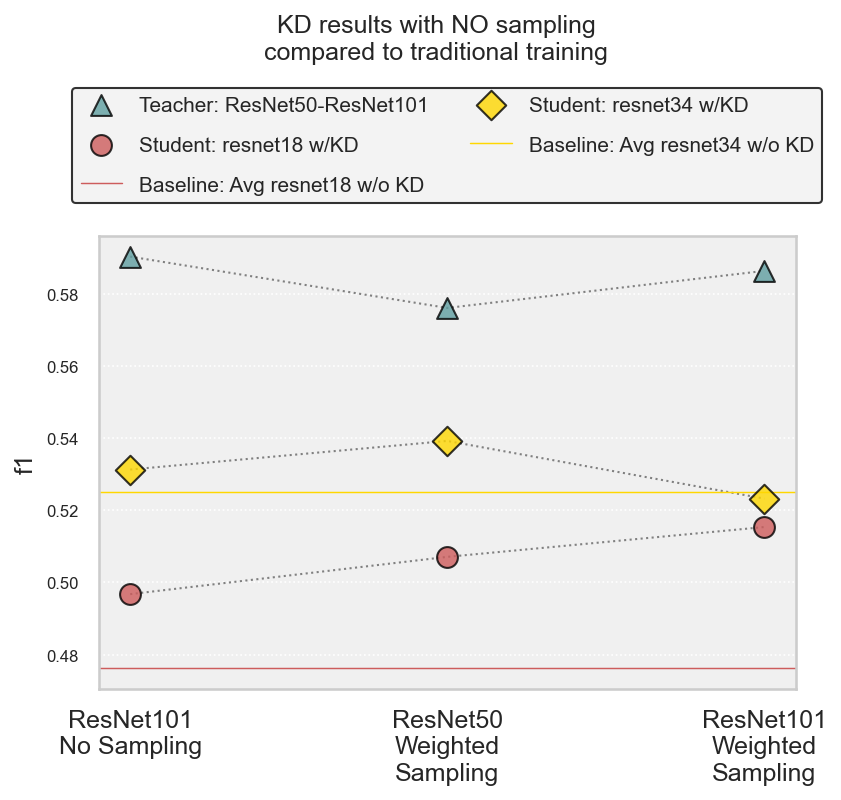

/tmp/ipykernel_978248/2139557204.py:46: UserWarning:

FixedFormatter should only be used together with FixedLocator



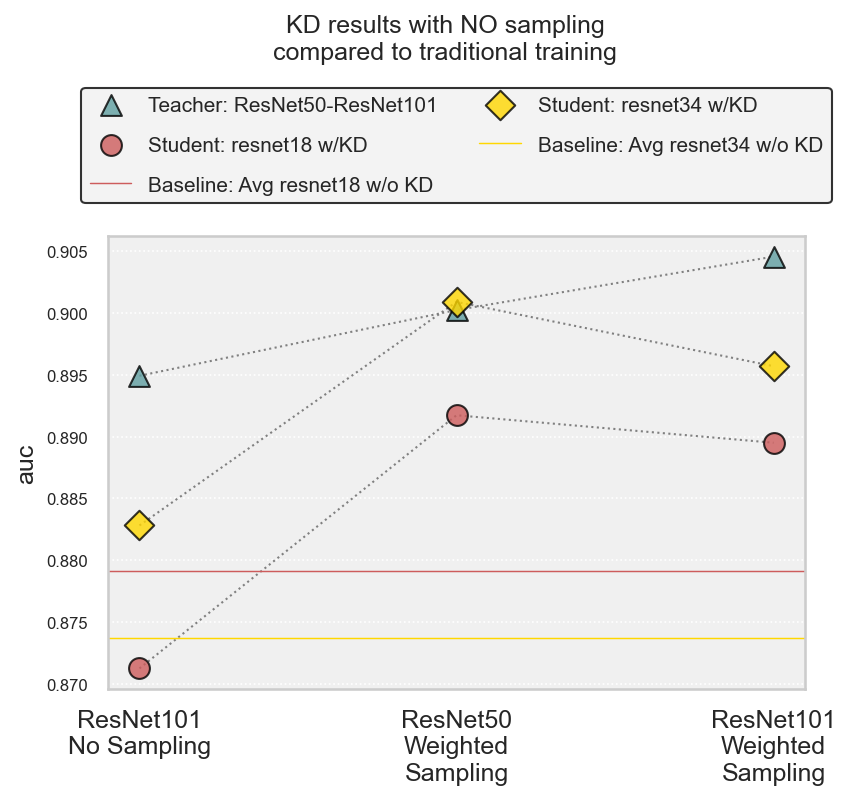

/tmp/ipykernel_978248/2139557204.py:46: UserWarning:

FixedFormatter should only be used together with FixedLocator



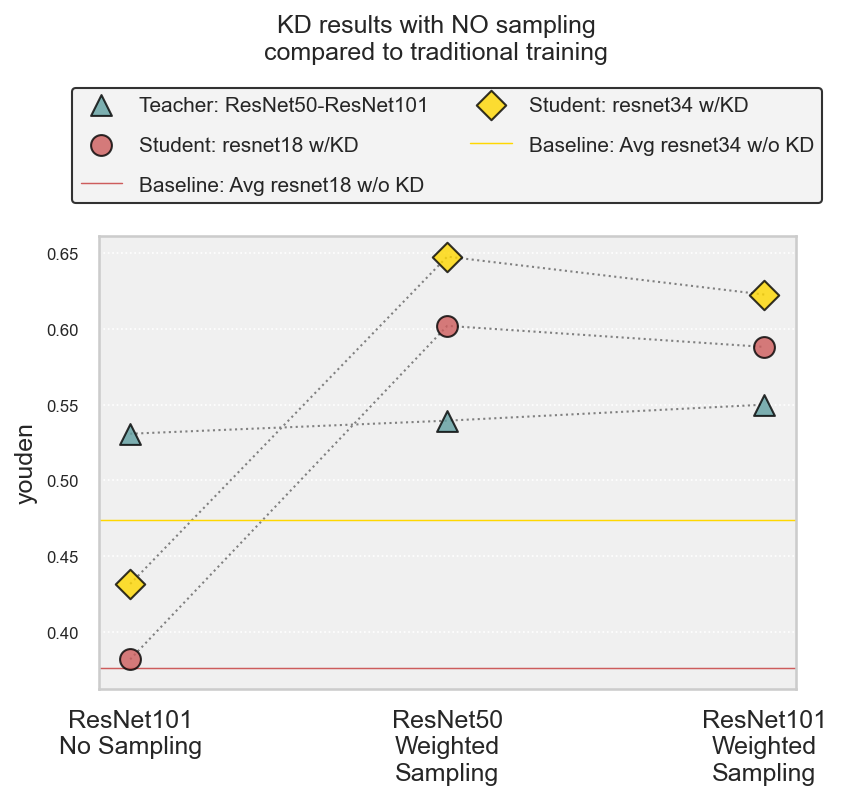

/tmp/ipykernel_978248/2139557204.py:46: UserWarning:

FixedFormatter should only be used together with FixedLocator



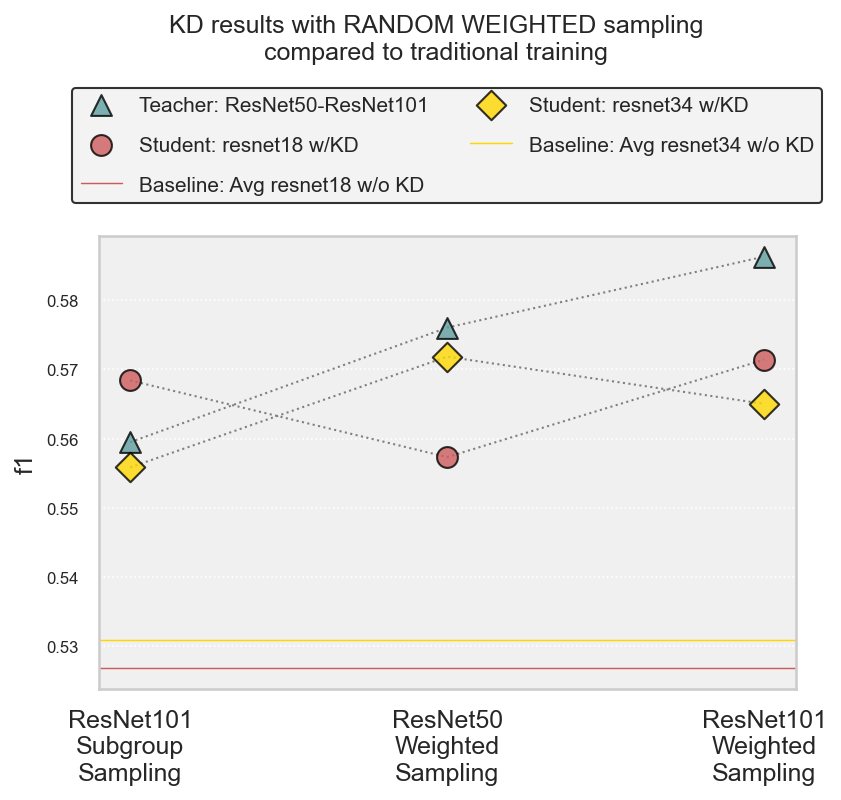

/tmp/ipykernel_978248/2139557204.py:46: UserWarning:

FixedFormatter should only be used together with FixedLocator



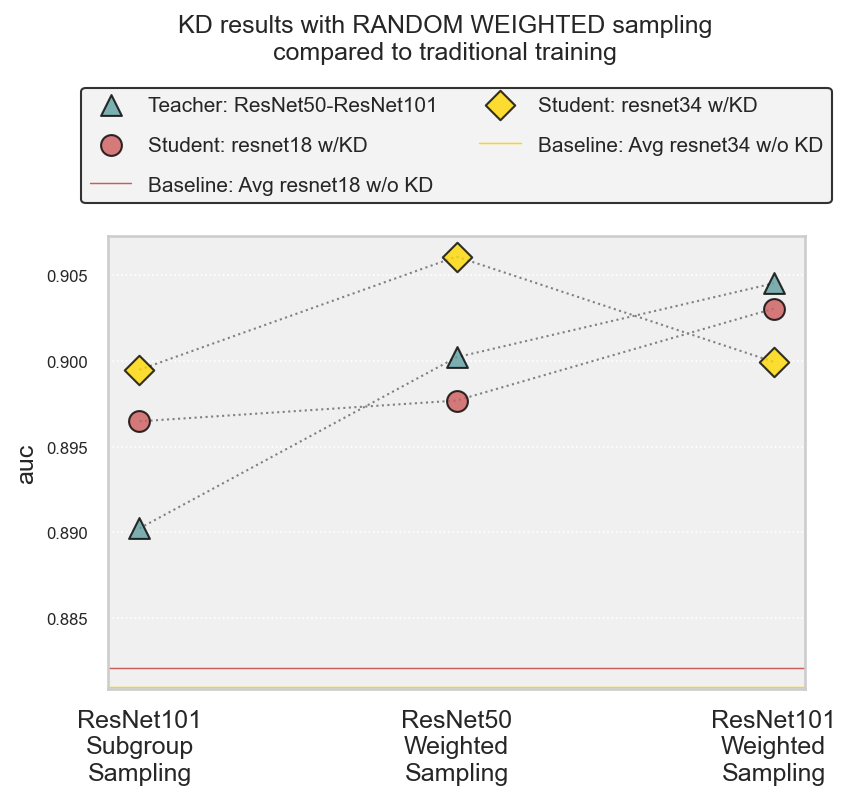

/tmp/ipykernel_978248/2139557204.py:46: UserWarning:

FixedFormatter should only be used together with FixedLocator



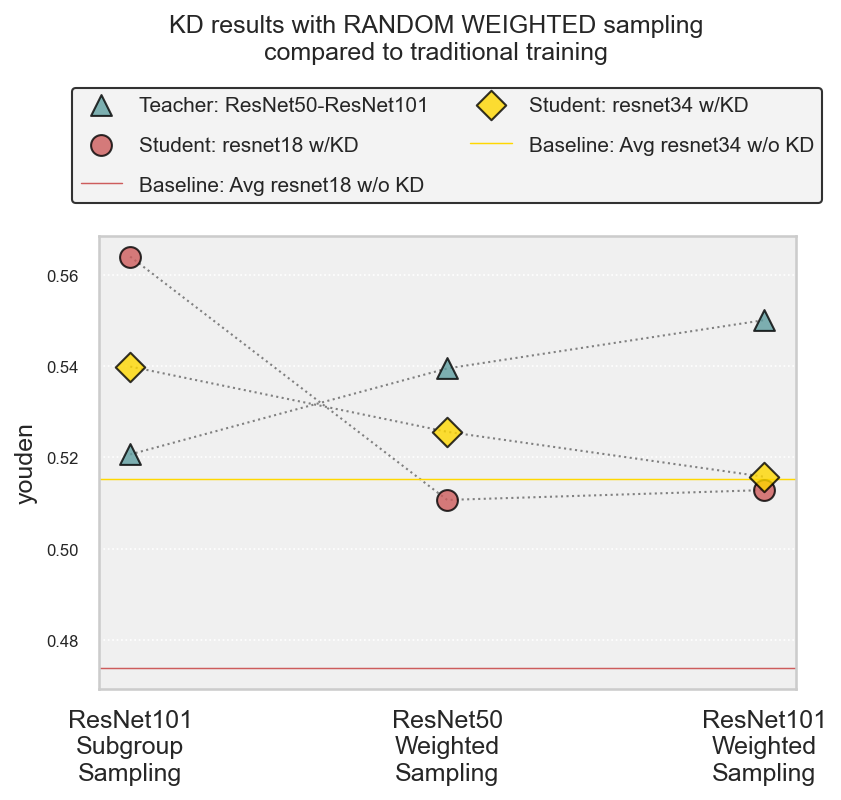

/tmp/ipykernel_978248/2139557204.py:46: UserWarning:

FixedFormatter should only be used together with FixedLocator



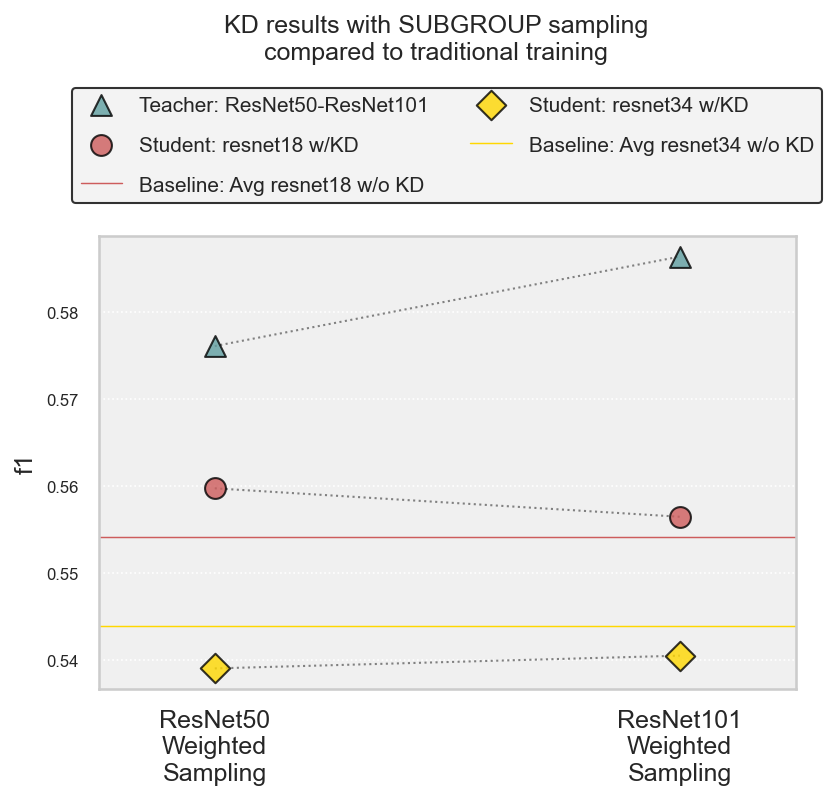

/tmp/ipykernel_978248/2139557204.py:46: UserWarning:

FixedFormatter should only be used together with FixedLocator



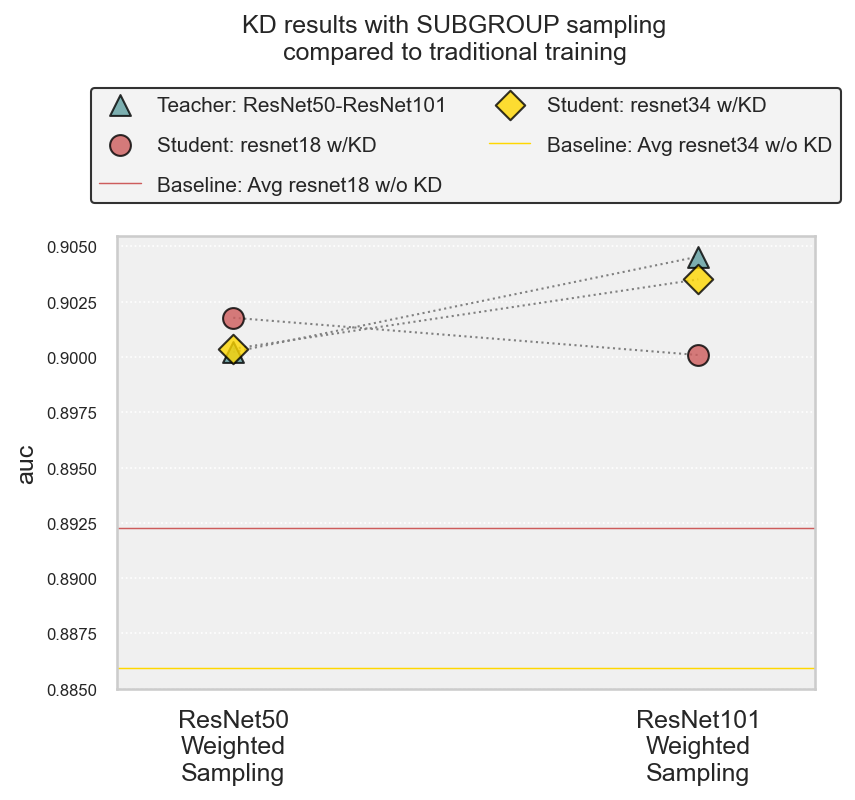

/tmp/ipykernel_978248/2139557204.py:46: UserWarning:

FixedFormatter should only be used together with FixedLocator



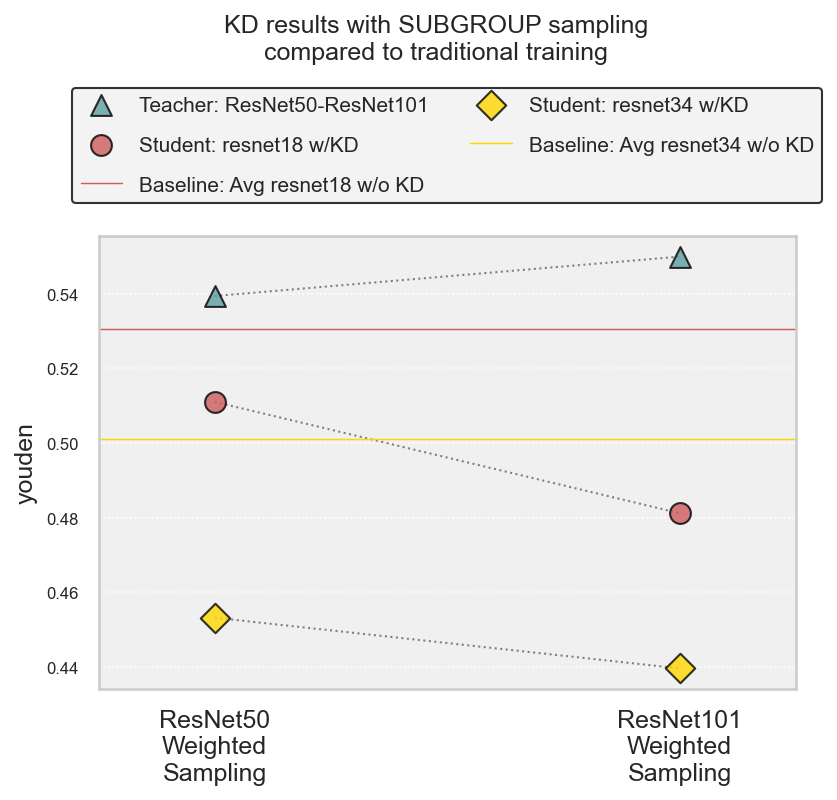

In [268]:
# List of setups that we have
for sampling in [0,1,2]:
    for metric in ['f1', 'auc', 'youden']:
        plot_kd_performance(
            resnet_df=resnet_test_df,
            kd_df = kd_test_df,
            metric=metric,
            teacher_ids=TEACHER_IDS,
            student_models=['resnet18', 'resnet34'],
            sampling_technique=sampling,
            title=f'KD results with {SAMPLING_TECHNIQUES_NAMES[sampling]} sampling\ncompared to traditional training',
            connect_markers=True,
        )

## KD Fairness Analysis

In [ ]:
def round_to_nearest_multiple_of_5(number):
    return round(number / 5) * 5

def get_subgroup_j_statistic_from_teacher_model(subgroup_df, model_name, experiment, seed):
    assert model_name in ("resnet18", "resnet34", "resnet50", "resnet101", "resnet152")
    subgroups = ['age', 'sex']
    j_group_names = ['J_change_group_0', 'J_change_group_1']
    
    data = []
    for subgroup in subgroups:
        for j_group in j_group_names:
            mask = (subgroup_df['subgroup'] == subgroup) & (subgroup_df['model'] == model_name) & (subgroup_df['experiment'] == experiment) & (subgroup_df['seed'] == seed)
            data.append(subgroup_df.loc[mask][j_group].values[0])
            
    return data

def calculate_teacher_subgroup_disparity(data, teachers):
    # Collect teacher data
    teacher_data = []
    for teacher_params in teachers:
        teacher, _, exp, seed = teacher_params
        teacher_data.append(data[(data['model']==teacher) & (data['seed']==seed) & (data['experiment']==exp)])              
    teacher_df = pd.concat(teacher_data)  

    # Calculate J_stat for each group
    teacher_df['J_statistic_group_0'] = teacher_df['tpr_group_0'] + teacher_df['tnr_group_0'] - 1
    teacher_df['J_statistic_group_1'] = teacher_df['tpr_group_1'] + teacher_df['tnr_group_1'] - 1

    # Calculate average J_stat.
    avg_df = teacher_df.groupby(['model', 'experiment', 'seed'])['J_statistic_group_0', 'J_statistic_group_1'].mean().mean(axis=1)
    avg_df.name = 'J_statistic'
    teacher_df = teacher_df.merge(avg_df, left_on=['model', 'experiment', 'seed'], right_index=True, how='left')
    
    # # Calculate relative change
    teacher_df['J_change_group_0'] = 100 * (teacher_df['J_statistic_group_0'] - teacher_df['J_statistic']) / teacher_df['J_statistic']
    teacher_df['J_change_group_1'] = 100 * (teacher_df['J_statistic_group_1'] - teacher_df['J_statistic']) / teacher_df['J_statistic']
    columns = {'subgroup': []}
    j_change_df = pd.DataFrame(columns)
    j_change_df['subgroup'] = ['age < 60', 'age 60+', 'male', 'female']

    for teacher_params in teachers:
        teacher, teacher_name, exp, seed = teacher_params
        j_change_df[teacher_name] = get_subgroup_j_statistic_from_teacher_model(teacher_df, teacher, exp, seed)
        
    return j_change_df


def plot_subgroup_disparity_for_teachers(data, teachers):
    data = calculate_teacher_subgroup_disparity(data, teachers)

    # plot the data with spacing between bars for each subgroup
    bar_width, bar_spacing = 0.12, 0.02
    fig, ax = plt.subplots(figsize=(10,5))
    for i, teacher_params in enumerate(teachers):
        _, teacher_name, experiment, _ = teacher_params
        x = np.arange(len(data['subgroup']))
        x = x + (i - len(teachers) // 2) * (bar_width + bar_spacing)
        ax.bar(x, data[teacher_name], width=bar_width, label=teacher_name, zorder=3)

    ax.set_xticks(np.arange(len(data['subgroup'])))
    ax.set_xticklabels(data['subgroup'])
    ax.legend()

    ax.grid(axis='y', zorder=0)
    grid_lines = ax.get_ygridlines()
    for line in grid_lines:
        line.set_color('lightgrey')
    
    ax.set_title("Relative change in disease detection performance across patient \nsubgroups in teacher models", fontsize=14)
    ax.set_xlabel('Subgroups', fontsize=14)
    ax.set_ylabel('Difference in % from average\n Youden\'s J statistic', fontsize=14)
    
    numeric_data = data.select_dtypes(include='number').values.tolist()
    
    min_value = round_to_nearest_multiple_of_5(np.min(numeric_data)) - 5
    max_value = round_to_nearest_multiple_of_5(np.max(numeric_data)) + 10
    ax.set_yticks(np.arange(min_value, max_value, 5))
    
    ax.set_facecolor('#F0F0F0')
    plt.show()
    
# Youden’s J statistic 
# J=sensitivity+specificity−1
# J = TPR + TNR - 1

### Relative Performance

In [269]:
def plot_relative_performance_for_teacher(
    df: pd.DataFrame,
    teacher_ids: dict[str, str] = TEACHER_IDS,
    metric: str = 'f1',
    title: str = '',
):

    sns.set(font_scale=1.2)
    sns.set_style("whitegrid")

    subgroup_metrics = [f'age_{metric}_group_0', f'age_{metric}_group_1', f'sex_{metric}_group_0', f'sex_{metric}_group_1']
    subgroup_metrics_names = {
        f'age_{metric}_group_0_relative_change': 'Age < 60',
        f'age_{metric}_group_1_relative_change': 'Age 60+',
        f'sex_{metric}_group_0_relative_change': 'Male',
        f'sex_{metric}_group_1_relative_change': 'Female',
    }

    # Filter the df to only include the models we want
    df = df[df['model_id'].isin(teacher_ids)]
    df = df[['model_id']+subgroup_metrics]

    # Calculate average metric
    avg_metric = 'avg_'+metric
    df[avg_metric] = df[subgroup_metrics].mean(axis=1)

    # Calculate relative change
    for column in subgroup_metrics:
        df[column + '_relative_change'] = (df[column] - df[avg_metric]) / df[avg_metric] * 100

    df = df.drop(columns=subgroup_metrics + [avg_metric])
    df = df.melt('model_id', var_name='metric', value_name='value')

    g = sns.catplot(
        data=df, kind="bar", x='metric', y='value', hue="model_id", height=5, aspect=1.6, width=0.5,
    )
    g._legend.remove()
    g.ax.set_axisbelow(True)

    # # Set the custom y-scale
    min_val = df['value'].min()
    max_val = df['value'].max()
    plt.ylim(min_val - 0.1 * abs(min_val), max_val + 0.1 * abs(max_val))

    # Add horizontal grid lines and make them dotted
    g.ax.yaxis.grid(True, linestyle='dotted')
    
    # Add border
    g.ax.spines['top'].set_visible(True)
    g.ax.spines['right'].set_visible(True)

    handles, labels = g.ax.get_legend_handles_labels()
    legend_names = [TEACHER_NAMES[label] for label in labels]
    legend = plt.legend(handles, legend_names, title='Teacher Model', handlelength=2, labelspacing=1.2)

    x_labels = [subgroup_metrics_names.get(metric, metric) for metric in df['metric'].unique()]
    g.ax.set_xticklabels(x_labels)

    # Set titles
    plt.xlabel('')
    plt.ylabel(f'Difference in % from average\n {metric}') 
    plt.title(title)

    # Move the legend outside and adjust its position
    legend.set_bbox_to_anchor((1.02, 0.9))  # Adjust the coordinates for desired positioning

    plt.rcParams['figure.dpi'] = 100
    plt.show()


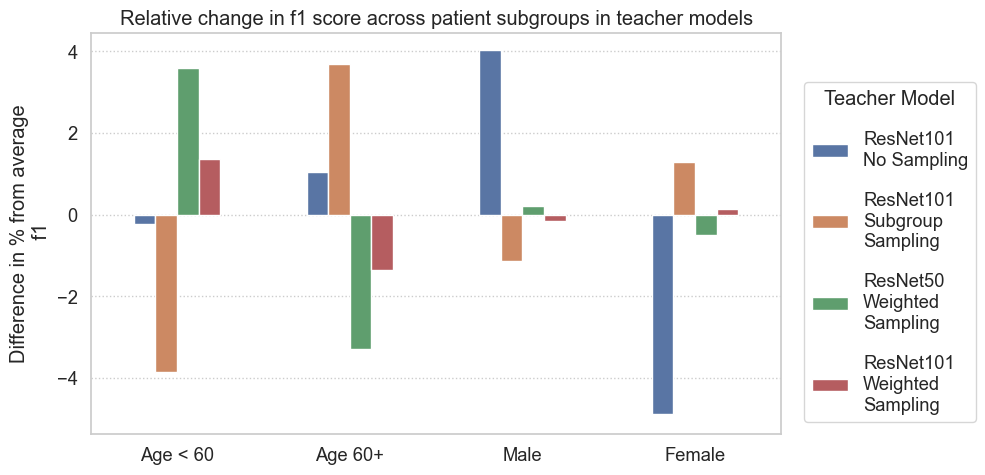

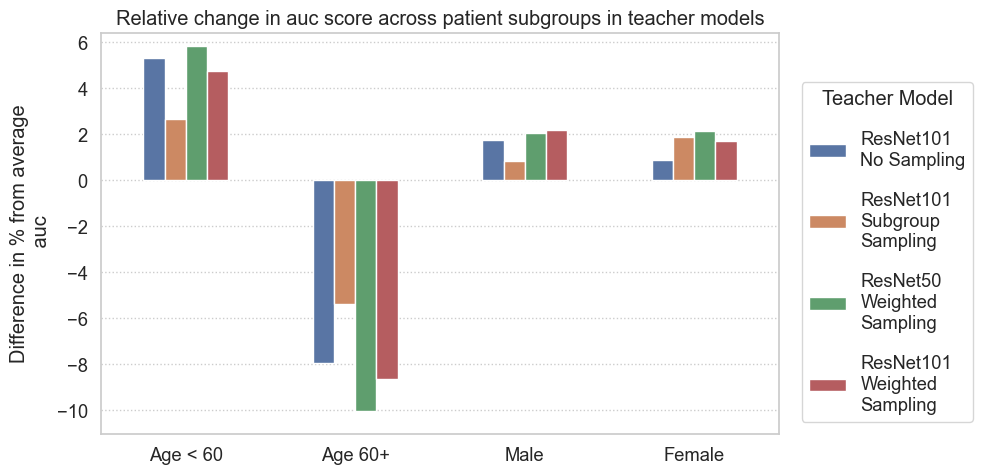

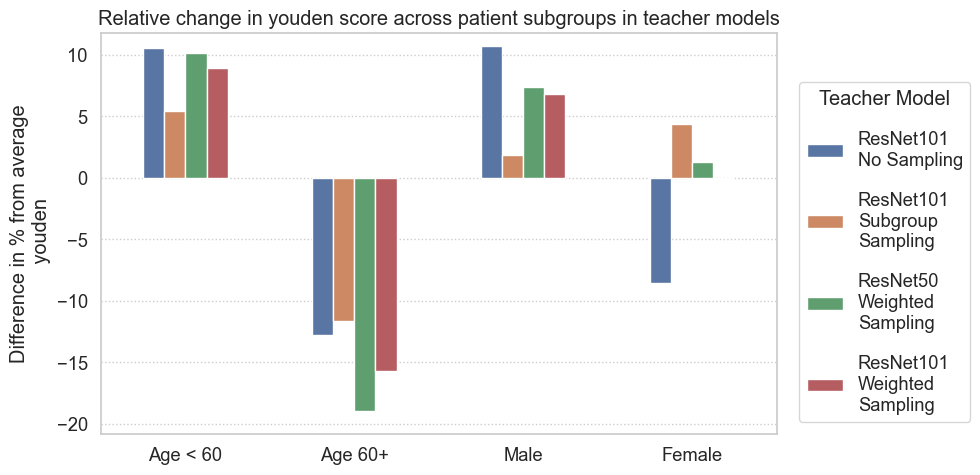

In [271]:

for metric in ['f1', 'auc', 'youden']:
    plot_relative_performance_for_teacher(
        df=resnet_test_df,
        teacher_ids=TEACHER_IDS,
        metric=metric,
        title=f'Relative change in {metric} score across patient subgroups in teacher models',
    )

### Relative Performance for Student and Teacher models together

In [72]:
def plot_relative_performance_for_students(
    df: pd.DataFrame,
    teacher_df: pd.DataFrame,
    teacher_id: str,
    sampling_technique: int = None,
    metric: str = 'f1',
    title: str = '',
):
    sns.set(font_scale=1.2)
    sns.set_style("whitegrid")

    subgroup_metrics = [f'age_{metric}_group_0', f'age_{metric}_group_1', f'sex_{metric}_group_0', f'sex_{metric}_group_1']
    subgroup_metrics_names = {
        f'age_{metric}_group_0_relative_change': 'Age < 60',
        f'age_{metric}_group_1_relative_change': 'Age 60+',
        f'sex_{metric}_group_0_relative_change': 'Male',
        f'sex_{metric}_group_1_relative_change': 'Female',
    }
    avg_metric = 'avg_'+metric

    # ------------------------
    # FILTER OUT THE TEACHER
    teacher_df = teacher_df[teacher_df['model_id'] == teacher_id]
    teacher_df = teacher_df[['model_name']+subgroup_metrics]
    teacher_df['model_name'] = TEACHER_NAMES[teacher_id]
    teacher_df[avg_metric] = teacher_df[subgroup_metrics].mean(axis=1)
    # Calculate relative change
    for column in subgroup_metrics:
        teacher_df[column + '_relative_change'] = (teacher_df[column] - teacher_df[avg_metric]) / teacher_df[avg_metric] * 100
    teacher_df = teacher_df.drop(columns=subgroup_metrics + [avg_metric])
    # ------------------------

    # ------------------------
    # FILTER OUT THE STUDENTS
    df = df[df['teacher_id'] == teacher_id]

    # if sampling_technique is None then we average across samplgin techniques else we only plot the sampling technique specified
    if sampling_technique is not None:
        df = df[df['sampling_technique'] == sampling_technique]
    df = df[['model_name', 'seed', 'sampling_technique', 'teacher_id']+subgroup_metrics]

    # Calculate average across seeds
    df = df.groupby(['model_name'])[subgroup_metrics].mean().reset_index()    
    df[avg_metric] = df[subgroup_metrics].mean(axis=1)

    # Calculate relative change
    for column in subgroup_metrics:
        df[column + '_relative_change'] = (df[column] - df[avg_metric]) / df[avg_metric] * 100
    df = df.drop(columns=subgroup_metrics + [avg_metric])
    # ------------------------

    # Concatenate teacher and student dataframes
    df = pd.concat([teacher_df, df], axis=0)
    df = df.melt('model_name', var_name='metric', value_name='value')

    # ------------------------
    # CREATE THE PLOT
    g = sns.catplot(
        data=df, kind="bar", x='metric', y='value', hue="model_name", height=5, aspect=1.6, width=0.5,
    )
    g._legend.remove()
    g.ax.set_axisbelow(True)

    # Set the custom y-scale
    min_val = df['value'].min()
    max_val = df['value'].max()
    plt.ylim(min_val - 0.1 * abs(min_val), max_val + 0.1 * abs(max_val))

    # Add horizontal grid lines and make them dotted
    g.ax.yaxis.grid(True, linestyle='dotted')
    
    # Add border
    g.ax.spines['top'].set_visible(True)
    g.ax.spines['right'].set_visible(True)

    legend = plt.legend(title='Models', handlelength=2, labelspacing=1.2)
    x_labels = [subgroup_metrics_names.get(metric, metric) for metric in df['metric'].unique()]
    g.ax.set_xticklabels(x_labels)

    # Set titles
    plt.xlabel('')
    plt.ylabel(f'Difference in % from average\n {metric}') 
    plt.title(title)

    # Move the legend outside and adjust its position
    legend.set_bbox_to_anchor((1.02, 0.9))  # Adjust the coordinates for desired positioning

    plt.rcParams['figure.dpi'] = 100
    plt.show()


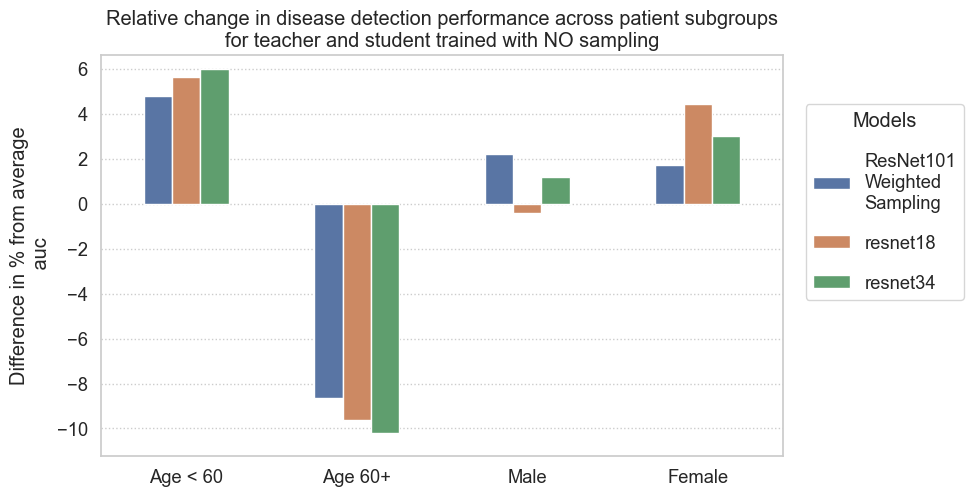

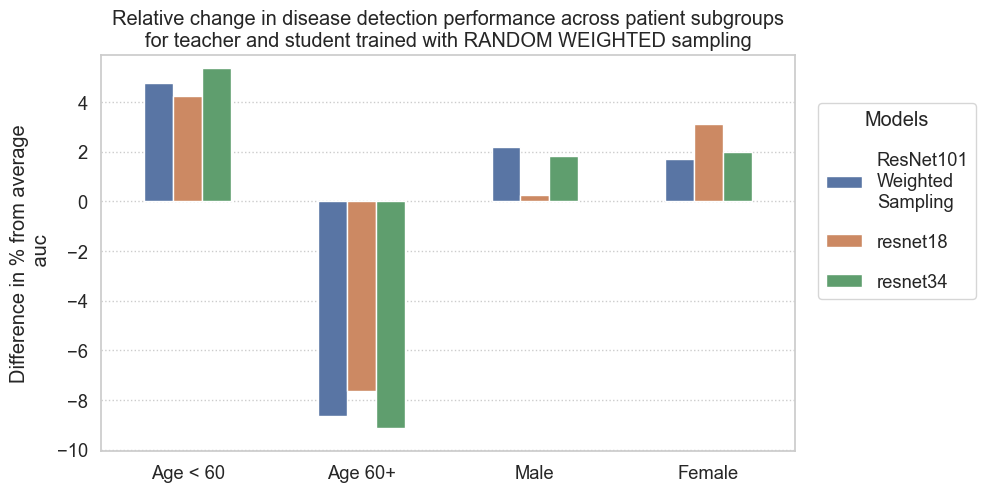

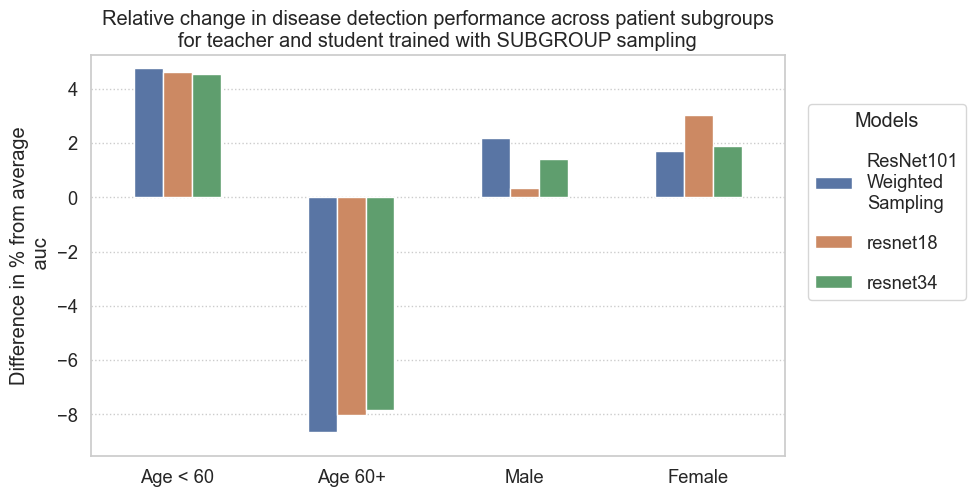

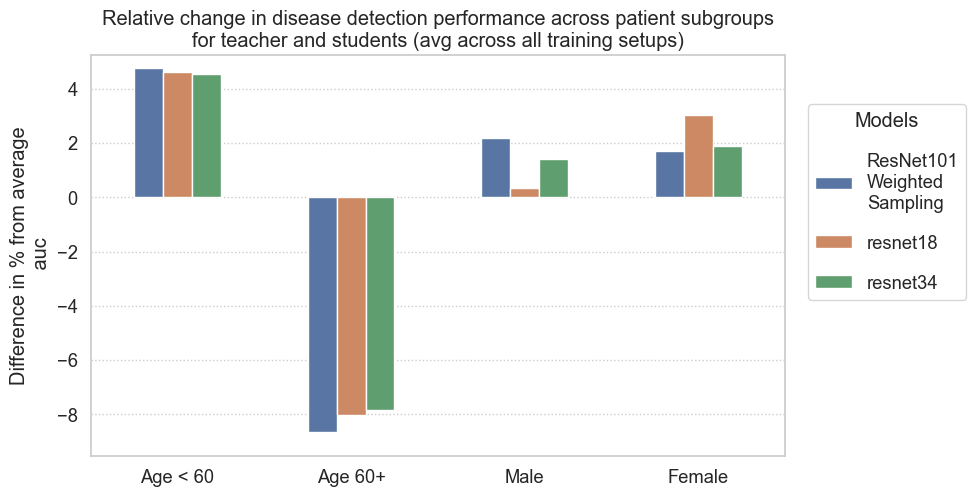

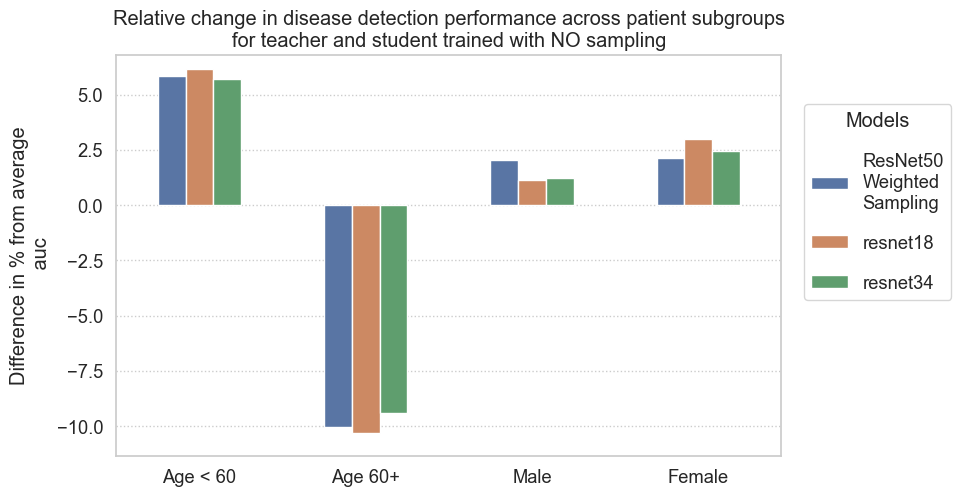

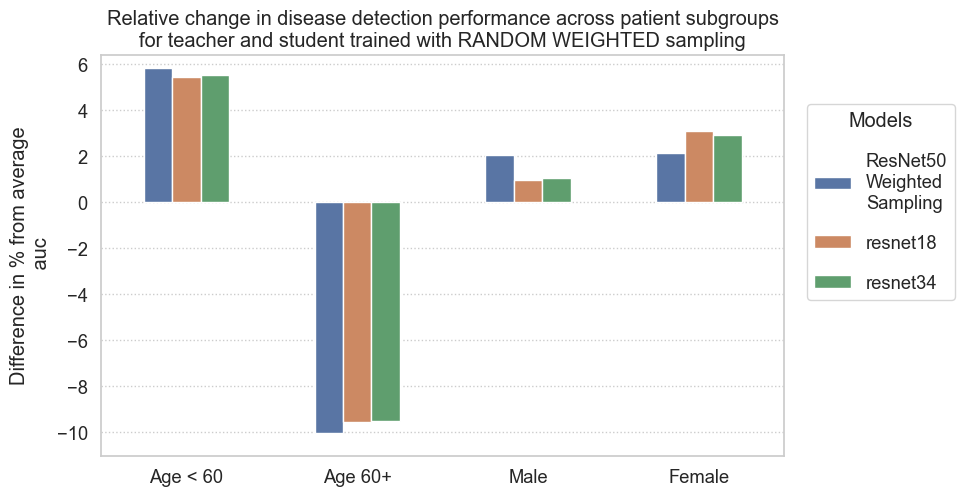

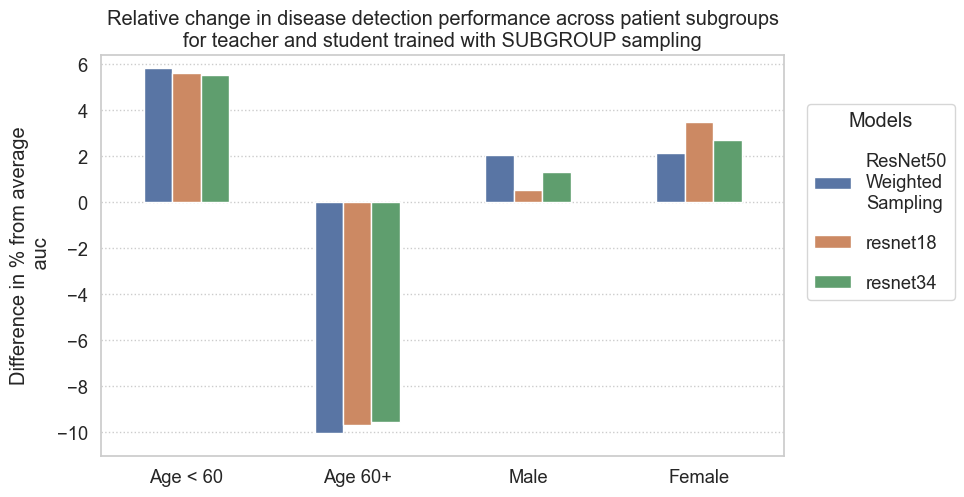

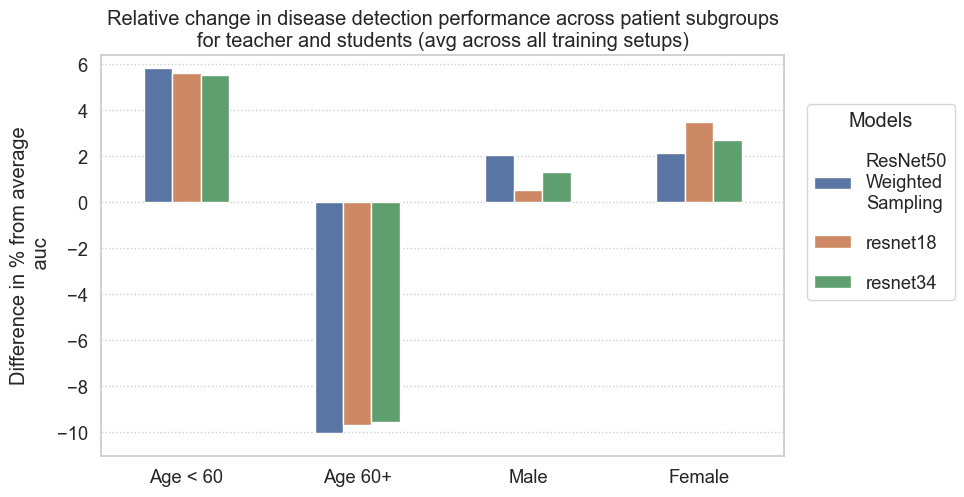

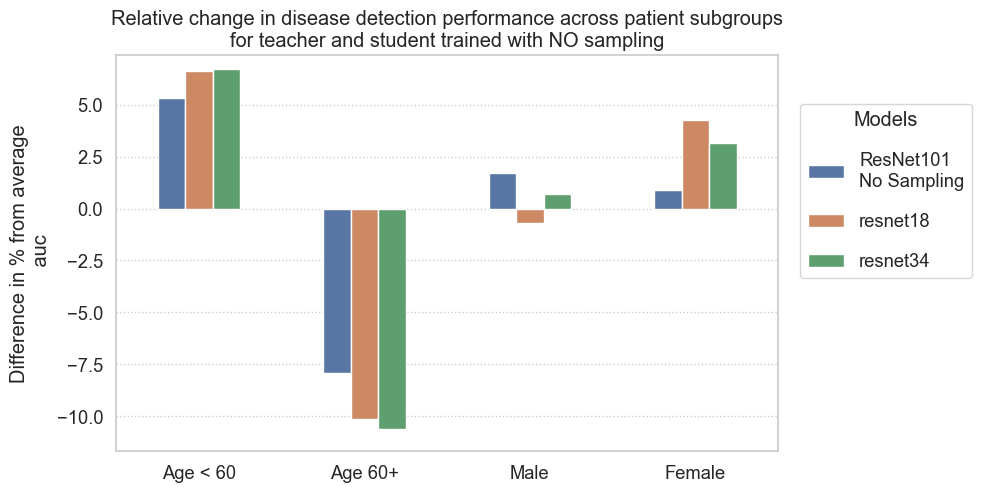

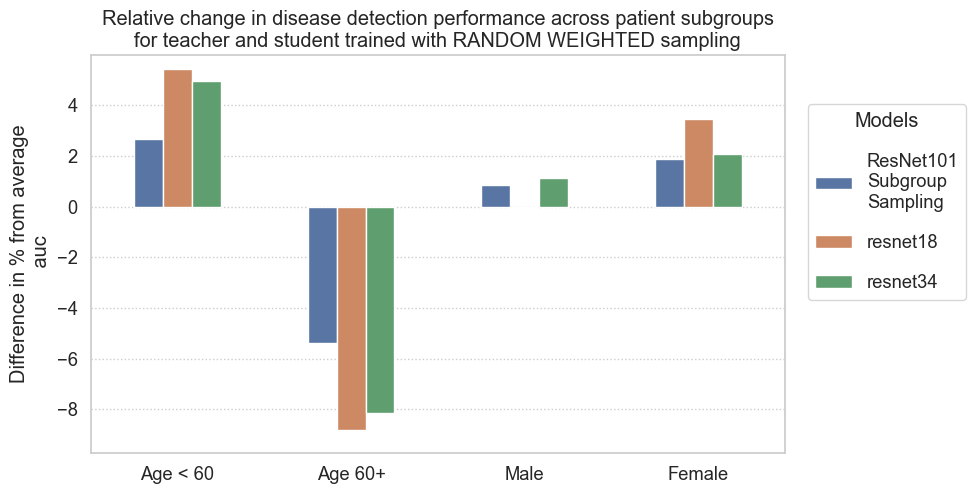

In [74]:
# TEACHER: r101-sam1-s43 and r50-sam1-s44 with sam0, sam1, sam2
for teacher_id in ['r101-sam1-s43', 'r50-sam1-s44']:
    for sampling_technique in [0, 1, 2]:
        for metric in ['auc']:
            plot_relative_performance_for_students(
                df=kd_test_df,
                teacher_df=resnet_test_df,
                teacher_id=teacher_id,
                sampling_technique = sampling_technique,
                metric=metric,
                title=f'Relative change in disease detection performance across patient subgroups\nfor teacher and student trained with {SAMPLING_TECHNIQUES_NAMES[sampling_technique]} sampling'
            )
    for metric in ['auc']:
        plot_relative_performance_for_students(
            df=kd_test_df,
            teacher_df=resnet_test_df,
            teacher_id=teacher_id,
            sampling_technique = sampling_technique,
            metric=metric,
            title=f'Relative change in disease detection performance across patient subgroups\nfor teacher and students (avg across all training setups)'
        )


# TEACHER: r101-sam0-s43 and sam0
for sampling_technique in [0]:
    for metric in ['auc']:
        plot_relative_performance_for_students(
            df=kd_test_df,
            teacher_df=resnet_test_df,
            teacher_id='r101-sam0-s43',
            sampling_technique = sampling_technique,
            metric=metric,
            title=f'Relative change in disease detection performance across patient subgroups\nfor teacher and student trained with {SAMPLING_TECHNIQUES_NAMES[sampling_technique]} sampling'
        )

# TEACHER: r101-sam2-s42 and sam1
for sampling_technique in [1]:
        for metric in ['auc']:
            plot_relative_performance_for_students(
                df=kd_test_df,
                teacher_df=resnet_test_df,
                teacher_id='r101-sam2-s42',
                sampling_technique = sampling_technique,
                metric=metric,
                title=f'Relative change in disease detection performance across patient subgroups\nfor teacher and student trained with {SAMPLING_TECHNIQUES_NAMES[sampling_technique]} sampling'
            )

In [75]:
def plot_teachers_fairness(
        resnet_df,
        kd_df,
        teacher_ids: list[str],
        metric: str = 'f1',
        title: str = 'Fairness of teacher and student models',
):
        sns.set(font_scale=1.2)
        sns.set_style("whitegrid")

        # ------------------------
        # GET THE TEACHER DATA
        resnet_df = resnet_df[resnet_df['model_id'].isin(teacher_ids)]
        resnet_df = resnet_df[['model_id', metric]]
        resnet_df['model_name'] = 'Teacher'
        resnet_df = resnet_df.rename(columns={'model_id': 'teacher_id'})
        # ------------------------

        # ------------------------
        # GET THE STUDENT DATA
        kd_df = kd_df[kd_df['teacher_id'].isin(teacher_ids)]
        kd_df = kd_df[['model_name', 'teacher_id', 'seed', 'sampling_technique', metric]]

        # filter the data to only include the same sampling technique that was used in the teacher
        # kd_df = kd_df[kd_df['teacher_id'].map(TEACHER_SAMPLING) == kd_df['sampling_technique']]
        
        # Calculate average across seeds
        kd_df = kd_df.groupby(['model_name', 'teacher_id'])[metric].mean().reset_index()    

        # Merge the dataframes
        merged_df = pd.concat([resnet_df, kd_df], ignore_index=True)
        merged_df['teacher_id'] = merged_df['teacher_id'].map(TEACHER_NAMES)
        plt.figure(figsize=(10, 6))
        # Plot the grouped barplot
        ax = sns.barplot(data=merged_df, x='teacher_id', y=metric, hue='model_name')

        # Set the custom y-scale
        min_val = merged_df[metric].min()
        max_val = merged_df[metric].max()
        plt.ylim(min_val - 0.1 * abs(min_val), max_val + 0.1 * abs(max_val))

        # Add horizontal grid lines and make them dotted
        ax.yaxis.grid(True, linestyle='dotted')

        # Add border
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)

        legend = plt.legend(title='Models', handlelength=2, labelspacing=1.2)

        # Set titles
        plt.xlabel('')
        plt.ylabel(metric) 
        plt.title(title)

        # Move the legend outside and adjust its position
        # legend.set_bbox_to_anchor((1.02, 0.9))  # Adjust the coordinates for desired positioning




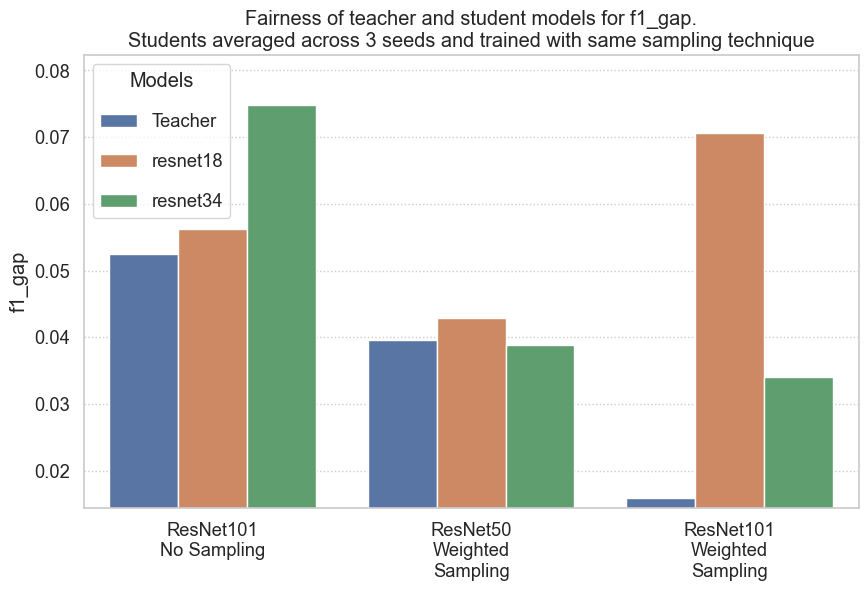

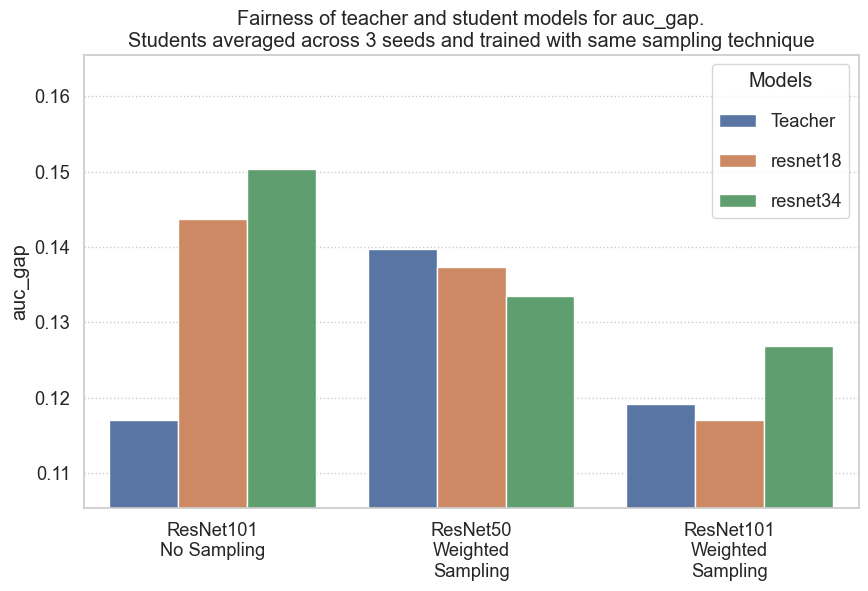

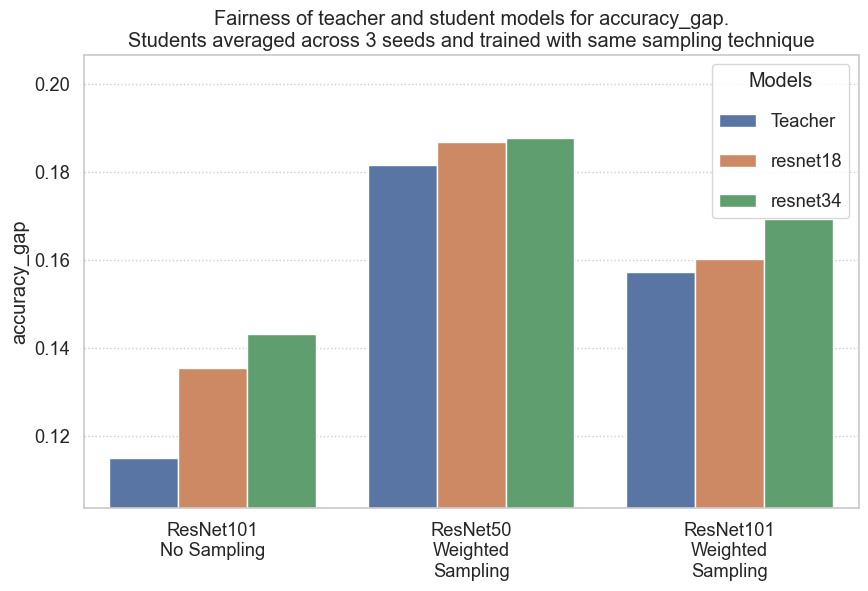

In [194]:
for metric in ['f1_gap', 'auc_gap', 'accuracy_gap']:
    plot_teachers_fairness(
    resnet_df=resnet_test_df,
    kd_df = kd_test_df,
    teacher_ids=['r101-sam0-s43', 'r101-sam1-s43', 'r50-sam1-s44'],
    metric=metric,
    title=f'Fairness of teacher and student models for {metric}.\nStudents averaged across 3 seeds and trained with same sampling technique',
)

In [240]:
def plot_overall_subgroup_performance(
    resnet_df: pd.DataFrame,
    kd_df: pd.DataFrame,
    teacher_id: str,
    metric: str,
    title: str,
):
    subgroup_metrics = [f'age_{metric}', f'sex_{metric}']
    subgroup_metrics_names = {
        f'age_{metric}': 'Age',
        f'sex_{metric}': 'Sex',
    }

    # GET THE TEACHER DATA
    resnet_df = resnet_df[resnet_df['model_id'] == teacher_id]
    resnet_df = resnet_df[['model_name']+subgroup_metrics]
    resnet_df['model_name'] = TEACHER_NAMES[teacher_id]

    # GET THE STUDENT DATA
    kd_df = kd_df[kd_df['teacher_id'] == teacher_id]
    kd_df['model_name'] = kd_df['model_name'] + '_sam' + kd_df['sampling_technique'].astype(str)
    kd_df = kd_df[['model_name', 'seed']+subgroup_metrics]
    kd_df = kd_df.groupby(['model_name'])[subgroup_metrics].mean().reset_index()
    
    # MERGE DFs
    merged_df = pd.concat([resnet_df, kd_df], ignore_index=True)
    merged_df = merged_df.melt('model_name', var_name='metric', value_name='value')

    # ------------------------
    # CREATE THE PLOT
    g = sns.catplot(
        data=merged_df, kind="bar", x='metric', y='value', hue="model_name", height=5, aspect=1.6, width=0.5,
    )
    g._legend.remove()
    g.ax.set_axisbelow(True)

    # Set the custom y-scale
    min_val = merged_df['value'].min()
    max_val = merged_df['value'].max()
    plt.ylim(min_val - 0.1 * abs(min_val), max_val + 0.1 * abs(max_val))

    # Add horizontal grid lines and make them dotted
    g.ax.yaxis.grid(True, linestyle='dotted')
    
    # Add border
    g.ax.spines['top'].set_visible(True)
    g.ax.spines['right'].set_visible(True)

    legend = plt.legend(title='Models', handlelength=2, labelspacing=1.2)
    x_labels = [subgroup_metrics_names.get(metric, metric) for metric in merged_df['metric'].unique()]
    g.ax.set_xticklabels(x_labels)

    # Set titles
    plt.xlabel('')
    plt.ylabel(metric) 
    plt.title(title)

    # Move the legend outside and adjust its position
    legend.set_bbox_to_anchor((1.02, 0.9))  # Adjust the coordinates for desired positioning

    plt.rcParams['figure.dpi'] = 100
    plt.show()




In [ ]:
# Can only do metrics that I have 2 of in the df (1 for each subgroup)

for teacher_id in ['r101-sam1-s43', 'r50-sam1-s44', 'r101-sam0-s43', 'r101-sam2-s42']:
    for metric in ['dp', 'eq_odds', 'eq_opportunity', 'tpr_diff']:
        plot_overall_subgroup_performance(
            resnet_df=resnet_test_df,
            kd_df=kd_test_df,
            teacher_id=teacher_id,
            metric=metric,
            title='Overall performance for ',
        )

# Stefan Plots

In [70]:
teacher_df = resnet_test_df[resnet_test_df['model_id'].isin(TEACHER_IDS)]
teacher_df.to_csv('teacher.csv')


## Bar Plot

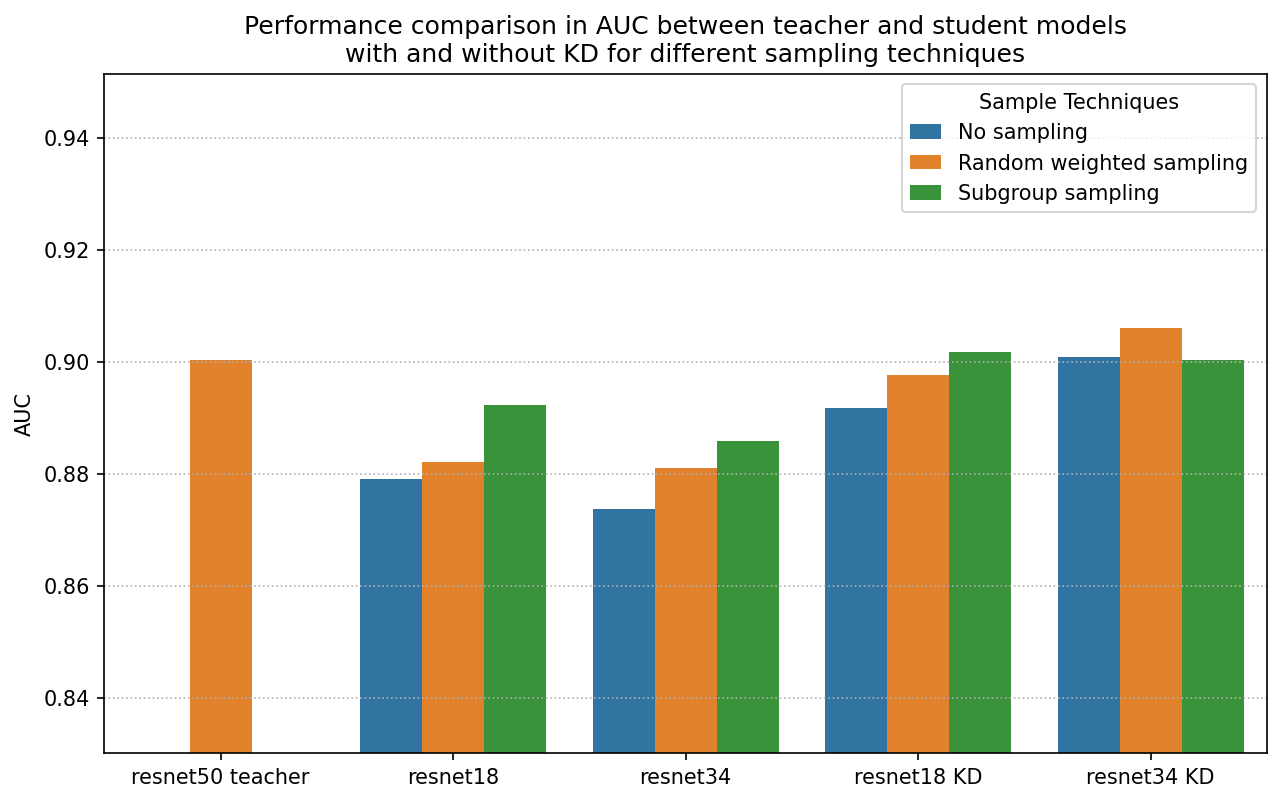

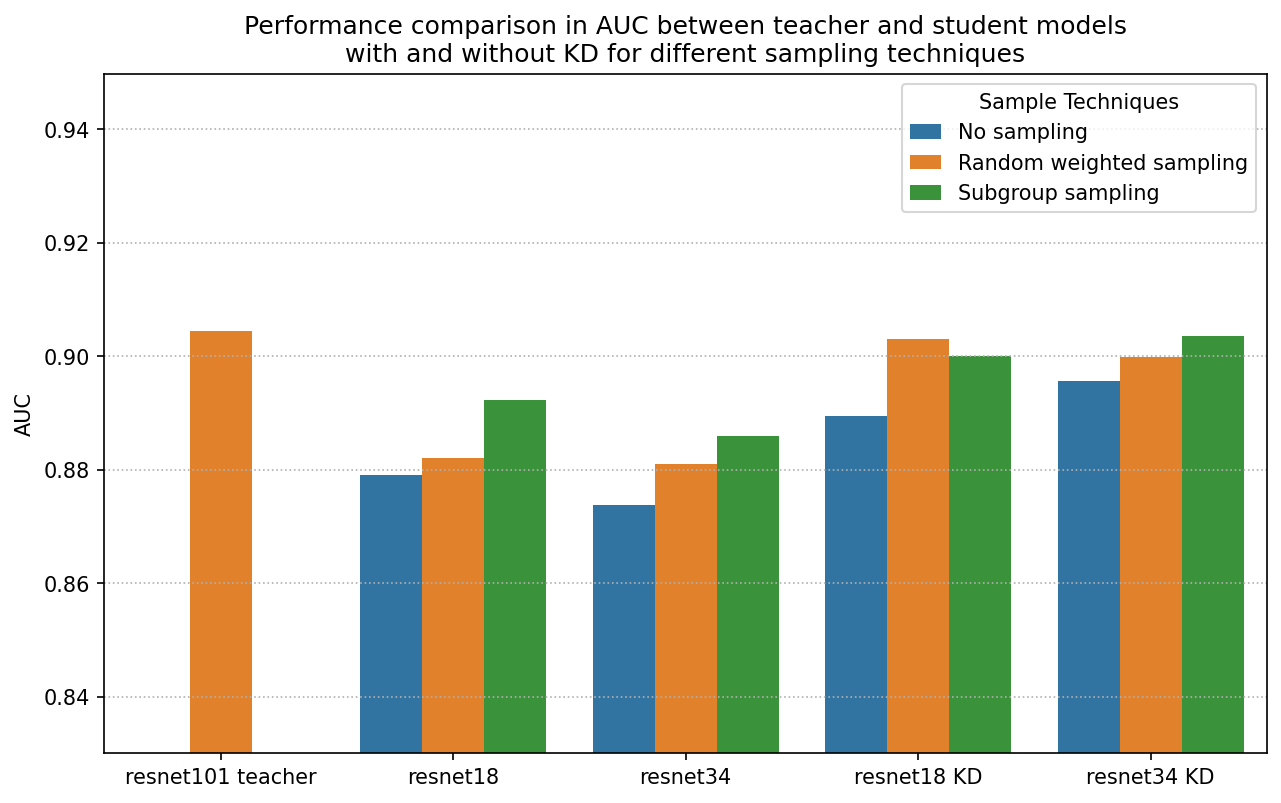

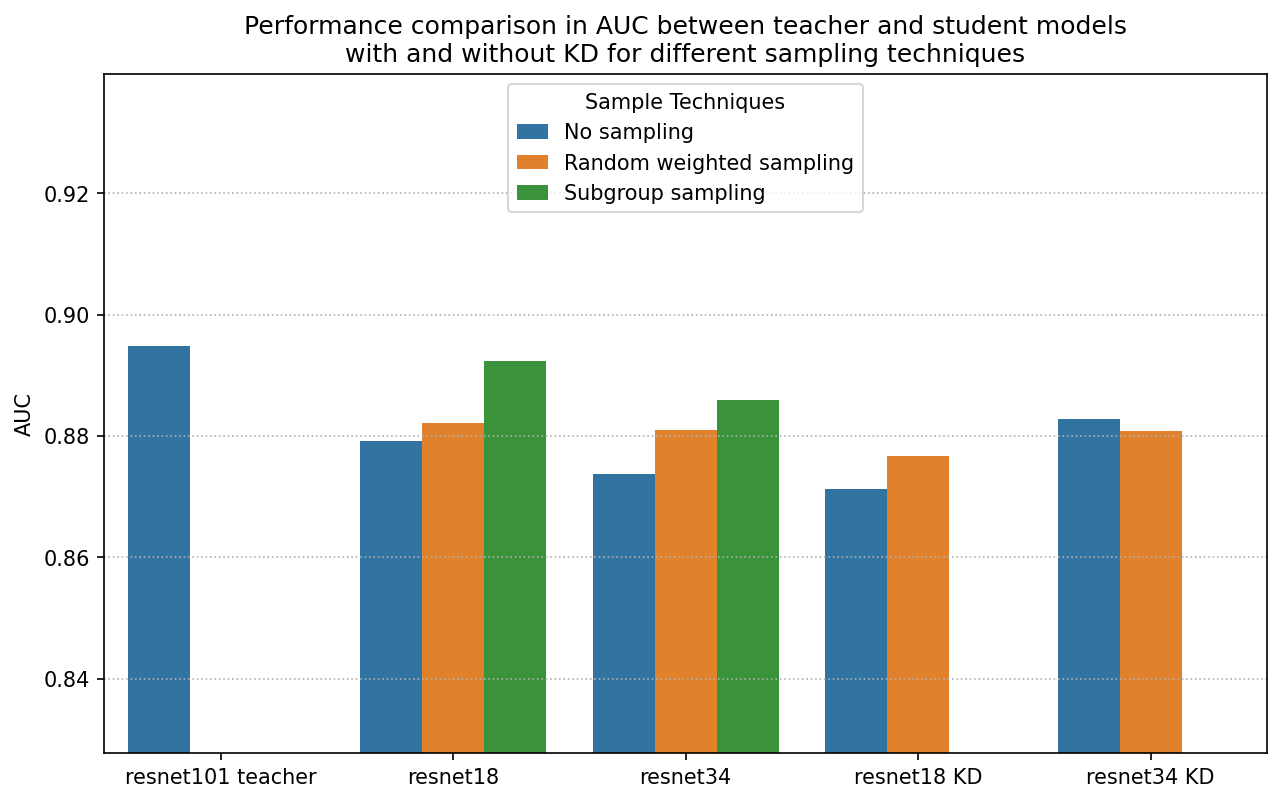

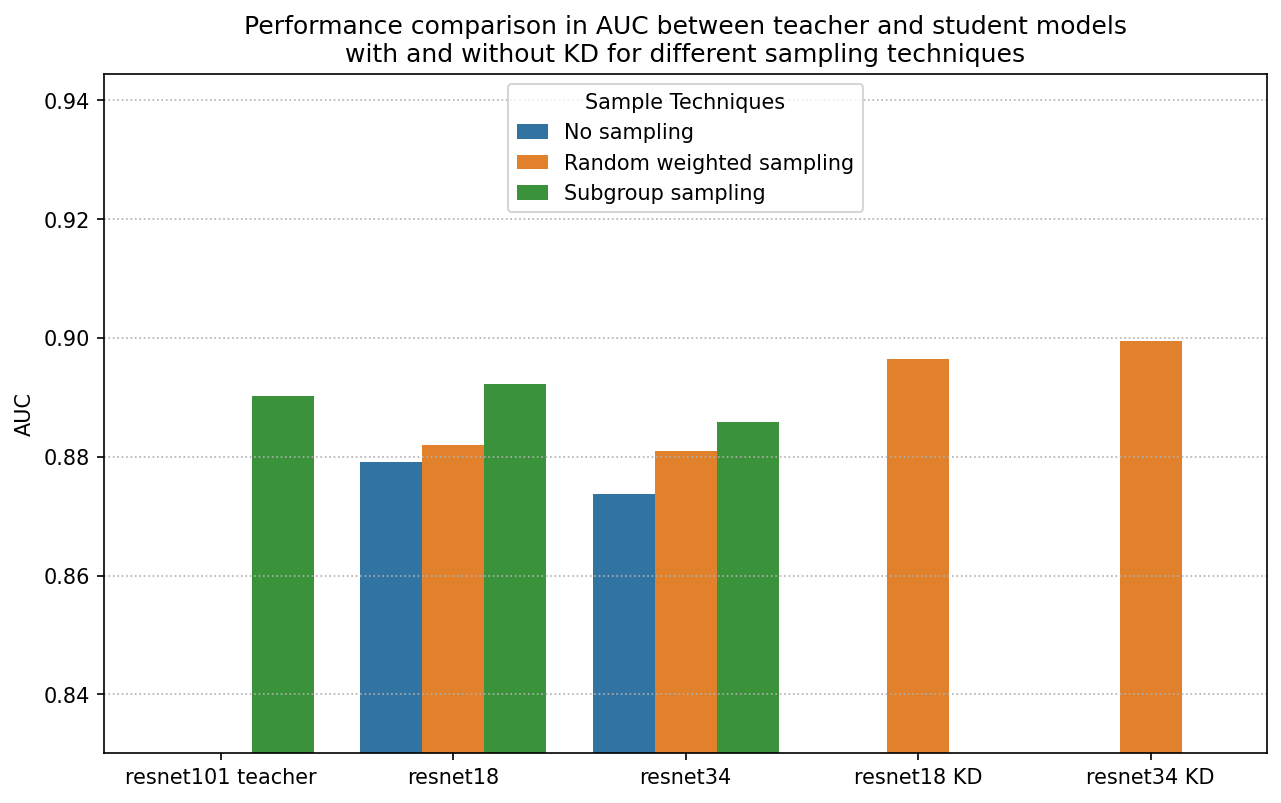

In [69]:
def create_teacher_student_performance_comparison_plot(
    resnet_df: pd.DataFrame,
    kd_df: pd.DataFrame,
    teacher_id: str,
    metric: str,
    labels: list[str] = [
        'No sampling',
        'Random weighted sampling',
        'Subgroup sampling'
    ],
    title: str = '',
):
    # Get the teacher data
    teacher_df = resnet_df[resnet_df['model_id'] == teacher_id]
    teacher_df = teacher_df[['model_name', 'sampling_technique', 'auc']]
    teacher_df['model_name'] = teacher_df['model_name'] + ' teacher'

    # Get the baseline data
    baseline_df = resnet_df[resnet_df['model_name'].isin(['resnet18', 'resnet34'])]
    baseline_df = baseline_df.groupby(['model_name', 'sampling_technique'])[metric].mean().reset_index() # get mean metric
    
    # Get the student data
    kd_df = kd_df[kd_df['teacher_id'] == teacher_id]
    kd_df = kd_df.groupby(['model_name', 'sampling_technique'])[metric].mean().reset_index() # get mean metric
    kd_df['model_name'] = kd_df['model_name'] + " KD"

    # Merge the dfs
    df = pd.concat([teacher_df, baseline_df, kd_df], ignore_index=True)

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=df, x='model_name', y=metric, hue='sampling_technique')

    # Set the custom y-scale
    min_val = df[metric].min()
    max_val = df[metric].max()
    plt.ylim(min_val - 0.05 * abs(min_val), max_val + 0.05 * abs(max_val))

    # Add horizontal grid lines and make them dotted
    ax.yaxis.grid(True, linestyle='dotted')

    # Add border
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)

    handles, _ = ax.get_legend_handles_labels()
    legend = plt.legend(handles, labels, title='Sample Techniques', handlelength=1.5)

    # Set titles
    plt.xlabel('')
    plt.ylabel(metric.upper()) 
    title=f'Performance comparison in {metric.upper()} between teacher and student models\nwith and without KD for different sampling techniques'
    plt.title(title)


for teacher in TEACHER_IDS:
    create_teacher_student_performance_comparison_plot(
        resnet_df=resnet_test_df,
        kd_df=kd_test_df,
        teacher_id=teacher,
        metric='auc',
    )

## HeatMap
- Relative performance compared to their teachers
- Relative performance compared to their no KD performance
- Normal Performance
- Fairness
- Maybe put it in a table as well

In [87]:
from matplotlib.colors import LinearSegmentedColormap
from copy import copy

def create_heatmap(
        resnet_df,
        kd_df,
        metric,
        title = '',
        relative_performance: bool = False,
        relative_to: str = 'student',
        fairness: bool = False,
):
        # Create teacher datadframe
        teacher_df = resnet_df[resnet_df['model_id'].isin(TEACHER_IDS)]
        teacher_df = teacher_df[['model_name', 'model_id', metric]]
        teacher_df = teacher_df.sort_values(by=['model_id'], key=lambda x: x.map({k: v for v, k in enumerate(TEACHER_IDS)}))

        # Create the student dataframe
        student_df = kd_df[['model_name', 'model_id', 'teacher_name', 'teacher_id', 'seed', 'sampling_technique', metric]]
        student_df = student_df.groupby(['model_name', 'teacher_id', 'sampling_technique'])[metric].mean().reset_index()
        student_df['name'] = student_df.apply(lambda row: row['model_name'] + " " + str(row['sampling_technique']), axis=1)
        
        # Get the baseline student performance
        baseline_df = resnet_df.groupby(['model_name', 'sampling_technique'])[metric].mean().reset_index()
        display(baseline_df)

        # Create the new dataframe using pivot_table
        new_df = pd.pivot_table(student_df, values=metric, index='teacher_id', columns='name')
        new_df = new_df.reindex(index=teacher_df['model_id'])
        display(new_df)

        # Relative performance compared to the student or teacher
        if relative_performance:
                if relative_to == 'teacher':
                        for column in new_df.columns:
                                teacher_f1 = teacher_df[[metric]].values
                                new_df[column] = (new_df[column] - teacher_f1.flatten()) / teacher_f1.flatten() * 100
                if relative_to == 'student':
                        for column in new_df.columns:
                                model_name, sampling_technique = column.split(' ')[0], column.split(' ')[1]
                                baseline_f1 = baseline_df.loc[(baseline_df['sampling_technique'] == int(sampling_technique)) &
                                                              (baseline_df['model_name'] == model_name), metric].values[0] 
                                baseline_list = [baseline_f1] * len(new_df)
                                new_df[column] = (new_df[column] - baseline_list) / baseline_list * 100

        fig, ax = plt.subplots(figsize=(10, 6))

        if relative_performance:
                # Define the color gradient for the colormap
                range = new_df.max().max() - new_df.min().min()
                zero_position = abs(new_df.min().min()) / range
                if fairness:
                        colors = [
                                (0, '#2ca02c'),  # red
                                (zero_position, '#ffffbf'),  # yellow
                                (1, '#d62728')
                        ]
                else:
                        colors = [
                                (0, '#d62728'),  # red
                                (zero_position, '#ffffbf'),  # yellow
                                (1, '#2ca02c') # green
                        ]  
                cmap = LinearSegmentedColormap.from_list('custom_colormap', colors)
        else:
                if fairness:
                        cmap = 'RdYlGn_r'
                else:
                        cmap = 'RdYlGn'

        new_df = new_df.rename(index=TEACHER_NAMES)

        # Add the baseline performance withotu KD
        new_df.loc[f'Student Baseline\n{metric} w/o KD'] = None
        for column_name, column_data in new_df.iteritems():
                model_name, sampling_technique = column_name.split(' ')[0], column_name.split(' ')[1]
                value = baseline_df.loc[(baseline_df['sampling_technique'] == int(sampling_technique)) &  (baseline_df['model_name'] == model_name), metric].values[0]
                new_df.at[f'Student Baseline\n{metric} w/o KD', column_name] = value

        # Rename the student models
        new_df.columns = new_df.columns.str.replace(r'(\d+)', lambda m: SAMPLING_TECHNIQUES_NAMES.get(int(m.group(0)), m.group(0)))  + '\nsampling'

        new_df = new_df.transpose()

        ### Heatmap with baseline performance (not coloured)
        data = new_df.to_numpy()
        data_for_colors = data.copy()
        data_for_colors[:, -1] = data.max() + 10.0
        # data_for_colors[-1, :] = data.max() + 10
        norm = plt.Normalize(data[:-1, :-1].min(), data[:-1, :-1].max())
        # cmap = sns.color_palette('rocket', as_cmap=True).copy()
        cmap = copy(plt.get_cmap('RdYlGn'))
        cmap.set_over('white')
        sns.set_style('white')

        sns.heatmap(data=data_for_colors, xticklabels=new_df.columns, yticklabels=new_df.index,
                annot=data, cmap=cmap, norm=norm, fmt='.4f')
        ax.set_xlabel('Teacher Models', fontsize=12)
        ax.xaxis.set_label_coords(0.5, -0.20)
        ax.set_ylabel('Student Models', fontsize=12)
        ax.set_title(title, fontsize=12)
        plt.show()

        ### OLD HEATMAP
        # heatmap = sns.heatmap(new_df.transpose(), annot=True, ax=ax, fmt='.4f', cmap=cmap)
        # ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        # ax.set_ylabel('Student Models', fontsize=12)
        # # Retrieve the x tick labels and rename them
        # x_tick_labels = [tick.get_text() for tick in ax.get_xticklabels()]
        # renamed_labels = [TEACHER_NAMES.get(label, label) for label in x_tick_labels]
        # ax.set_xticklabels(renamed_labels)
        # ax.set_xlabel('Teacher Models', fontsize=12)
        # ax.xaxis.set_label_coords(0.5, -0.20)
        
        # ax.set_title(title, fontsize=12)

        # plt.show()

model_name  sampling_technique       auc
0   resnet101                   0  0.888255
1   resnet101                   1  0.900015
2   resnet101                   2  0.889578
3    resnet18                   0  0.879144
4    resnet18                   1  0.882066
5    resnet18                   2  0.892283
6    resnet34                   0  0.873735
7    resnet34                   1  0.880992
8    resnet34                   2  0.885921
9    resnet50                   0  0.884592
10   resnet50                   1  0.893282
11   resnet50                   2  0.881626

name           resnet18 0  resnet18 1  resnet18 2  resnet34 0  resnet34 1  \
model_id                                                                    
r50-sam1-s44     0.891722    0.897697    0.901775    0.900882    0.906099   
r101-sam1-s43    0.889501    0.903060    0.900089    0.895687    0.899957   
r101-sam0-s43    0.871270    0.876783    0.875223    0.882818    0.880844   
r101-sam2-s42    0.876044    0.896486    0.900591    0.891470    0.899493   

name           resnet34 2  
model_id                   
r50-sam1-s44     0.900371  
r101-sam1-s43    0.903510  
r101-sam0-s43    0.877739  
r101-sam2-s42    0.900361

/tmp/ipykernel_2645816/1780286693.py:74: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/tmp/ipykernel_2645816/1780286693.py:75: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/tmp/ipykernel_2645816/1780286693.py:81: FutureWarning:

The default value of regex will change from True to False in a future version.



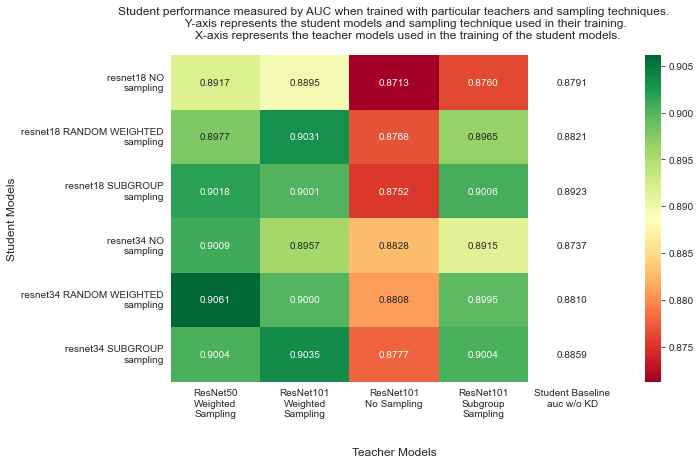

model_name  sampling_technique       auc
0   resnet101                   0  0.888255
1   resnet101                   1  0.900015
2   resnet101                   2  0.889578
3    resnet18                   0  0.879144
4    resnet18                   1  0.882066
5    resnet18                   2  0.892283
6    resnet34                   0  0.873735
7    resnet34                   1  0.880992
8    resnet34                   2  0.885921
9    resnet50                   0  0.884592
10   resnet50                   1  0.893282
11   resnet50                   2  0.881626

name           resnet18 0  resnet18 1  resnet18 2  resnet34 0  resnet34 1  \
model_id                                                                    
r50-sam1-s44     0.891722    0.897697    0.901775    0.900882    0.906099   
r101-sam1-s43    0.889501    0.903060    0.900089    0.895687    0.899957   
r101-sam0-s43    0.871270    0.876783    0.875223    0.882818    0.880844   
r101-sam2-s42    0.876044    0.896486    0.900591    0.891470    0.899493   

name           resnet34 2  
model_id                   
r50-sam1-s44     0.900371  
r101-sam1-s43    0.903510  
r101-sam0-s43    0.877739  
r101-sam2-s42    0.900361

/tmp/ipykernel_2645816/1780286693.py:74: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/tmp/ipykernel_2645816/1780286693.py:75: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/tmp/ipykernel_2645816/1780286693.py:81: FutureWarning:

The default value of regex will change from True to False in a future version.



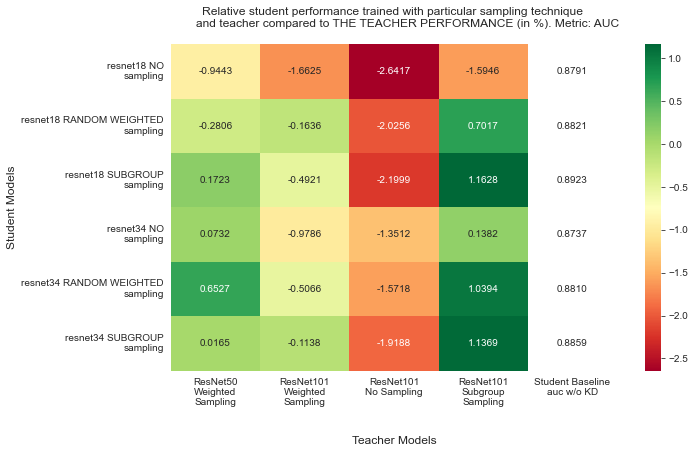

model_name  sampling_technique       auc
0   resnet101                   0  0.888255
1   resnet101                   1  0.900015
2   resnet101                   2  0.889578
3    resnet18                   0  0.879144
4    resnet18                   1  0.882066
5    resnet18                   2  0.892283
6    resnet34                   0  0.873735
7    resnet34                   1  0.880992
8    resnet34                   2  0.885921
9    resnet50                   0  0.884592
10   resnet50                   1  0.893282
11   resnet50                   2  0.881626

name           resnet18 0  resnet18 1  resnet18 2  resnet34 0  resnet34 1  \
model_id                                                                    
r50-sam1-s44     0.891722    0.897697    0.901775    0.900882    0.906099   
r101-sam1-s43    0.889501    0.903060    0.900089    0.895687    0.899957   
r101-sam0-s43    0.871270    0.876783    0.875223    0.882818    0.880844   
r101-sam2-s42    0.876044    0.896486    0.900591    0.891470    0.899493   

name           resnet34 2  
model_id                   
r50-sam1-s44     0.900371  
r101-sam1-s43    0.903510  
r101-sam0-s43    0.877739  
r101-sam2-s42    0.900361

/tmp/ipykernel_2645816/1780286693.py:74: FutureWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/tmp/ipykernel_2645816/1780286693.py:75: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/tmp/ipykernel_2645816/1780286693.py:81: FutureWarning:

The default value of regex will change from True to False in a future version.



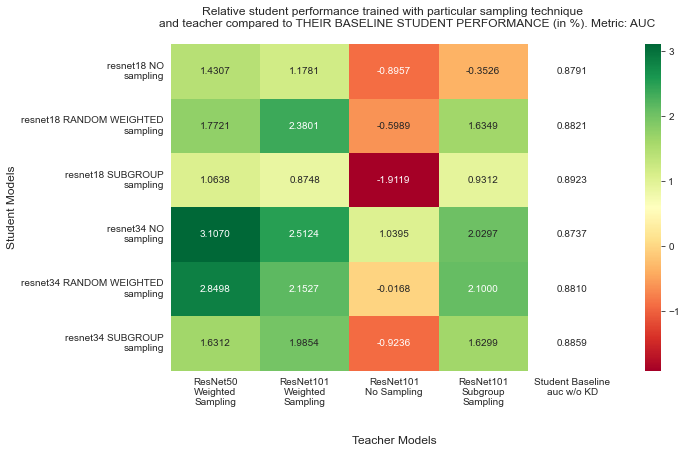

In [88]:
for metric in ['auc']:
    create_heatmap(
        resnet_df=resnet_test_df,
        kd_df=kd_test_df,
        metric=metric,
        title=f"""Student performance measured by {metric.upper()} when trained with particular teachers and sampling techniques.
        Y-axis represents the student models and sampling technique used in their training. 
        X-axis represents the teacher models used in the training of the student models.\n""",
    )       
    create_heatmap(
        resnet_df=resnet_test_df,
        kd_df=kd_test_df,
        metric=metric,
        relative_performance=True,
        relative_to='teacher',
        title=f"""Relative student performance trained with particular sampling technique 
        and teacher compared to THE TEACHER PERFORMANCE (in %). Metric: {metric.upper()}\n"""
    )
    
    create_heatmap(
        resnet_df=resnet_test_df,
        kd_df=kd_test_df,
        metric=metric,
        relative_performance=True,
        relative_to='student',
        title=f"""Relative student performance trained with particular sampling technique 
        and teacher compared to THEIR BASELINE STUDENT PERFORMANCE (in %). Metric: {metric.upper()}\n"""
    )

# for fairness_metric in ['auc_gap']:
#     create_heatmap(
#         resnet_df=resnet_test_df,
#         kd_df=kd_test_df,
#         metric=fairness_metric,
#         title=f"""Student performance measured by {fairness_metric.upper()} when trained with particular teachers and sampling techniques.
#         Y-axis represents the student models and sampling technique used in their training. 
#         X-axis represents the teacher models used in the training of the student models.\n""",
#         fairness=True
#     )       
#     create_heatmap(
#         resnet_df=resnet_test_df,
#         kd_df=kd_test_df,
#         metric=fairness_metric,
#         relative_performance=True,
#         relative_to='teacher',
#         title=f"""Relative student performance trained with particular sampling technique 
#         and teacher compared to THE TEACHER PERFORMANCE (in %). Metric: {fairness_metric.upper()}\n""",
#         fairness=True
#     )
    
#     create_heatmap(
#         resnet_df=resnet_test_df,
#         kd_df=kd_test_df,
#         metric=fairness_metric,
#         relative_performance=True,
#         relative_to='student',
#         title=f"""Relative student performance trained with particular sampling technique 
#         and teacher compared to THEIR BASELINE STUDENT PERFORMANCE (in %). Metric: {fairness_metric.upper()}\n""",
#         fairness=True
#     )

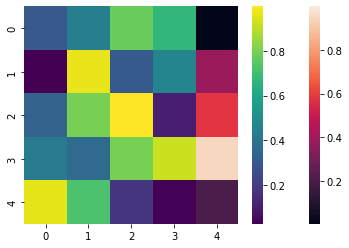

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Generate some random data for the heatmap
data = np.random.rand(5, 5)

# Create the heatmap using seaborn
heatmap = sns.heatmap(data)

# Set the color of a specific column to transparent or white
column_index = 4  # Index of the column you want to modify
color = 'transparent'  # 'transparent' or 'white'

# Modify the underlying data array to remove color from the specific column
if color == 'transparent':
    data[:, column_index] = np.nan
elif color == 'white':
    data[:, column_index] = 1.0

# Create a custom color map with transparency or white color
cmap = sns.color_palette("viridis", as_cmap=True)  # Choose a suitable colormap

# Plot the modified heatmap with the custom color map
sns.heatmap(data, cmap=cmap)

# Show the modified heatmap
plt.show()
